# Do DL models and training environments have an impact on the energy consumption of computer vision training?

## RQ1: What is the impact of model architecture on image classification training concerning energy efficiency and model correctness?

## RQ2: What is the impact of the training environment on image classification training concerning energy efficiency?

Author: Santiago del Rey


## Import libraries


In [1]:
import os
import sys
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import scikit_posthocs as sp
import seaborn as sns
import statsmodels.api as sm
from cliffs_delta import cliffs_delta
from scipy import stats
from statsmodels.formula.api import ols

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.features.analysis import (
    test_assumptions,
    boxplot,
    barplot,
    eta_squared,
    is_pareto_efficient,
    print_improvement,
)
from src.environment import CONFIGS_DIR, FIGURES_DIR, METRICS_DIR
from src.features.preprocessing import MJOULES_TO_JOULES, HOURS_TO_MILISECONDS

SAVE_FIGS = True
FIGURES_FORMAT = "pdf"
SAVE_FIGS_DIR = FIGURES_DIR / FIGURES_FORMAT

if not SAVE_FIGS_DIR.exists():
    os.makedirs(SAVE_FIGS_DIR)

sns.set_theme(style="whitegrid", context="paper", palette="colorblind", color_codes=True, font_scale=1.5)
plt.style.use(CONFIGS_DIR / "figures.mplstyle")

%matplotlib inline

Missing colon in file PosixPath('/home/santiago/Local-Projects/seaa2023_ect_extension/config/figures.mplstyle'), line 9 ('legend.fancybox = "true"')


## Load the dataset


In [2]:
analysis_df = pd.read_parquet(
    os.path.join(METRICS_DIR, "processed", "clean-dl-training-energy-consumption-dataset.gzip")
)
print(analysis_df.shape)
analysis_df.head()

(1225, 45)


,training environment,architecture,dataset,run_id,start time,training duration (h),measured epochs,gpu model,gpu working time (h),gpu usage (%),...,image size,GFLOPs,accuracy,AUC,split number,precision,recall,f1-score,total seen images,return code
0,Cloud,mobilenet_v2,chesslive-occupancy,ed5f9d5907ee495fb655e7e90aff1fac,2022-12-05 09:55:44.537,0.735028,86,NVIDIA GeForce RTX 3090,0.168889,22.995461,...,"(128, 128)",0.064028,0.975629,0.995675,0,0.959826,0.993169,0.976213,2919872,0.0
1,Cloud,mobilenet_v2,chesslive-occupancy,782109dee17a4c399030b0822155591f,2022-12-05 10:47:16.997,0.796192,92,NVIDIA GeForce RTX 3090,0.182600,22.952514,...,"(128, 128)",0.064028,0.971108,0.992465,0,0.957560,0.986339,0.971736,3123584,0.0
2,Cloud,mobilenet_v2,chesslive-occupancy,b85c1287f4344b7996bffcd15d890d86,2022-12-05 11:41:08.533,0.472226,55,NVIDIA GeForce RTX 3090,0.105261,22.303708,...,"(128, 128)",0.064028,0.960397,0.987073,0,0.956488,0.965262,0.960855,1867360,0.0
3,Cloud,mobilenet_v2,chesslive-occupancy,5a4800e73d8241b19bb9369dd74295f9,2022-12-05 12:15:34.087,0.634343,74,NVIDIA GeForce RTX 3090,0.144261,22.758107,...,"(128, 128)",0.064028,0.974941,0.994777,0,0.962921,0.988290,0.975441,2512448,0.0
4,Cloud,mobilenet_v2,chesslive-occupancy,29bb5be7abd140b68c106c87604df9a9,2022-12-05 12:59:41.666,0.662704,76,NVIDIA GeForce RTX 3090,0.150069,22.661493,...,"(128, 128)",0.064028,0.968553,0.990629,0,0.957524,0.981070,0.969154,2580352,0.0


## Data analysis


In [3]:
TRAIN_STRATEGIES = ["Local N", "Local ML", "Cloud"]
MARKERS = {
    "MobileNet V2": "o",
    "NASNet Mobile": "v",
    "Xception": "^",
    "ResNet50": "X",
    "VGG16": "P",
}
COLORS = {"Local N": "b", "Local ML": "orange", "Cloud": "g"}
ARCHITECTURE_LABELS = ["MobileNet\nV2", "NASNet\nMobile", "ResNet50", "VGG16", "Xception"]

analysis_df.query("architecture != 'inception_v3'", inplace=True)
analysis_df.rename(
    columns={
        "energy (MJ)": "energy",
        "gpu usage (%)": "gpu_usage",
        "average temperature (Celsius)": "temperature",
        "emissions (tCO2e)": "emissions",
    },
    inplace=True,
)

analysis_df.replace(
    {
        "Local Normal User": "Local N",
        "Local ML Engineer": "Local ML",
        "mobilenet_v2": "MobileNet V2",
        "nasnet_mobile": "NASNet Mobile",
        "xception": "Xception",
        "resnet50": "ResNet50",
        "vgg16": "VGG16",
    },
    inplace=True,
)

analysis_df["raw energy"] = analysis_df.energy.copy()
analysis_df["energy"] = analysis_df["raw energy"] * MJOULES_TO_JOULES / analysis_df["total seen images"]
analysis_df["normalized duration"] = (
    analysis_df["training duration (h)"] * HOURS_TO_MILISECONDS / analysis_df["total seen images"]
)

In [4]:
local_n_mobilenet = analysis_df.query("`training environment` == 'Local N' & architecture == 'MobileNet V2'")
local_n_nasnet = analysis_df.query("`training environment` == 'Local N' & architecture == 'NASNet Mobile'")

local_ml_mobilenet = analysis_df.query("`training environment` == 'Local ML' & architecture == 'MobileNet V2'")
local_ml_nasnet = analysis_df.query("`training environment` == 'Local ML' & architecture == 'NASNet Mobile'")
local_ml_xception = analysis_df.query("`training environment` == 'Local ML' & architecture == 'Xception'")
local_ml_resnet50 = analysis_df.query("`training environment` == 'Local ML' & architecture == 'ResNet50'")
local_ml_vgg16 = analysis_df.query("`training environment` == 'Local ML' & architecture == 'VGG16'")


cloud_mobilenet = analysis_df.query("`training environment` == 'Cloud' & architecture == 'MobileNet V2'")
cloud_nasnet = analysis_df.query("`training environment` == 'Cloud' & architecture == 'NASNet Mobile'")
cloud_xception = analysis_df.query("`training environment` == 'Cloud' & architecture == 'Xception'")
cloud_resnet50 = analysis_df.query("`training environment` == 'Cloud' & architecture == 'ResNet50'")
cloud_vgg16 = analysis_df.query("`training environment` == 'Cloud' & architecture == 'VGG16'")

### Impact of temperature on energy consumption


Looking at the scatter plot of the temperature vs. energy, we do not observe any clear correlation between the two variables in a general view. However, this might not be the case when we look at the data for each environment separately.


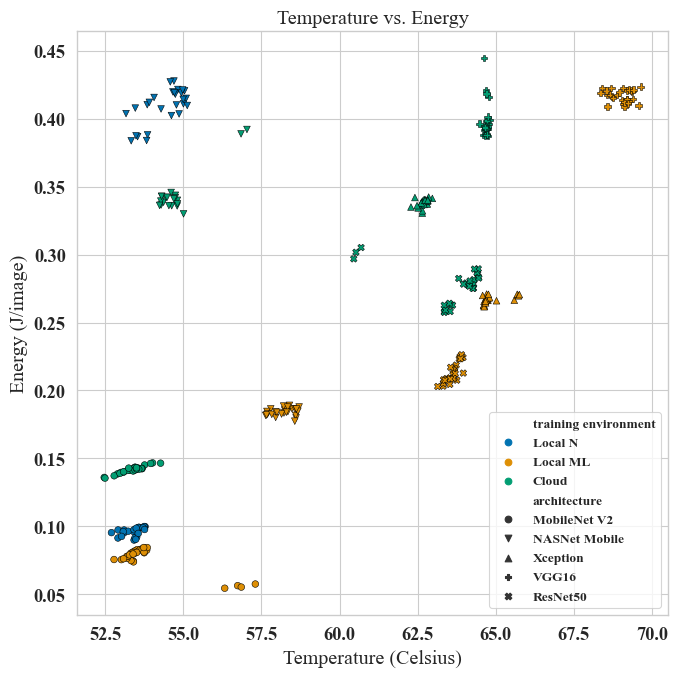

In [5]:
_, axes = plt.subplots(1, 1, figsize=((7, 7)))
ax = sns.scatterplot(
    analysis_df,
    x="temperature",
    y="energy",
    ax=axes,
    style="architecture",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    markers=MARKERS,
    edgecolor="black",
)
ax.set_title("Temperature vs. Energy")
ax.set_xlabel("Temperature (Celsius)")
ax.set_ylabel("Energy (J/image)")
ax.legend(fontsize="x-small")

if SAVE_FIGS:
    plt.savefig(os.path.join(SAVE_FIGS_DIR, f"temperature-energy-scatter.{FIGURES_FORMAT}"))

plt.show()

#### Test normality assumption

Before performing any statistical analysis, we need to check if the data is normally distributed. We do this by observing the Q-Q plot of the data and by performing the Shapiro-Wilk test.


Shapiro test for normality of group 0: W = 0.7648234367370605 and p-value 4.820462605470421e-13. Is normaly distributed? False
Shapiro test for normality of group 1: W = 0.8493301272392273 and p-value 4.2697961832871556e-10. Is normaly distributed? False
Levene test for equal variances: W = 135.02311127279867 and p-value = 2.5867236612861546e-25. Equal variances? False


([ShapiroResult(statistic=0.7648234367370605, pvalue=4.820462605470421e-13),
  ShapiroResult(statistic=0.8493301272392273, pvalue=4.2697961832871556e-10)],
 LeveneResult(statistic=135.02311127279867, pvalue=2.5867236612861546e-25))

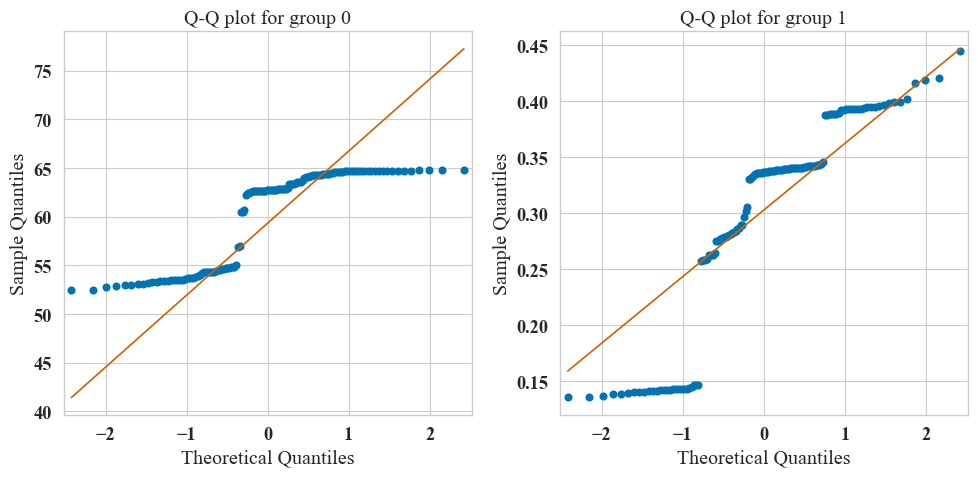

In [6]:
cloud_df = analysis_df.query("`training environment` == 'Cloud'")
test_assumptions(cloud_df["temperature"], cloud_df["energy"], nrows=1, ncols=2, figsize=(10, 5))

Shapiro test for normality of group 0: W = 0.9073910713195801 and p-value 0.000514488376211375. Is normaly distributed? False
Shapiro test for normality of group 1: W = 0.6782116889953613 and p-value 1.3347858374146426e-09. Is normaly distributed? False
Levene test for equal variances: W = 46.01225618142847 and p-value = 6.927661993337883e-10. Equal variances? False


([ShapiroResult(statistic=0.9073910713195801, pvalue=0.000514488376211375),
  ShapiroResult(statistic=0.6782116889953613, pvalue=1.3347858374146426e-09)],
 LeveneResult(statistic=46.01225618142847, pvalue=6.927661993337883e-10))

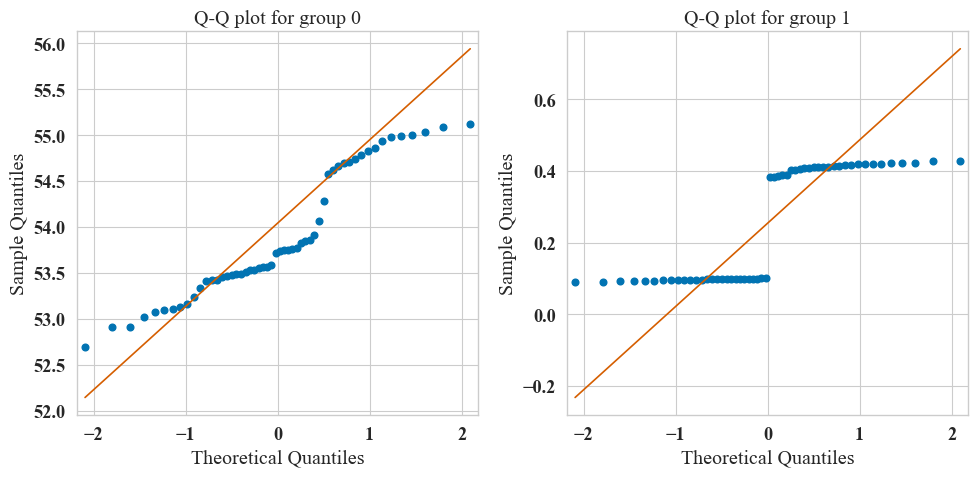

In [7]:
local_n_df = analysis_df.query("`training environment` == 'Local N'")
test_assumptions(local_n_df["temperature"], local_n_df["energy"], nrows=1, ncols=2, figsize=(10, 5))

Shapiro test for normality of group 0: W = 0.8980912566184998 and p-value 2.0760737129421614e-08. Is normaly distributed? False
Shapiro test for normality of group 1: W = 0.8908275365829468 and p-value 8.507649695843611e-09. Is normaly distributed? False
Levene test for equal variances: W = 232.18606222760422 and p-value = 1.1598358095593316e-38. Equal variances? False


([ShapiroResult(statistic=0.8980912566184998, pvalue=2.0760737129421614e-08),
  ShapiroResult(statistic=0.8908275365829468, pvalue=8.507649695843611e-09)],
 LeveneResult(statistic=232.18606222760422, pvalue=1.1598358095593316e-38))

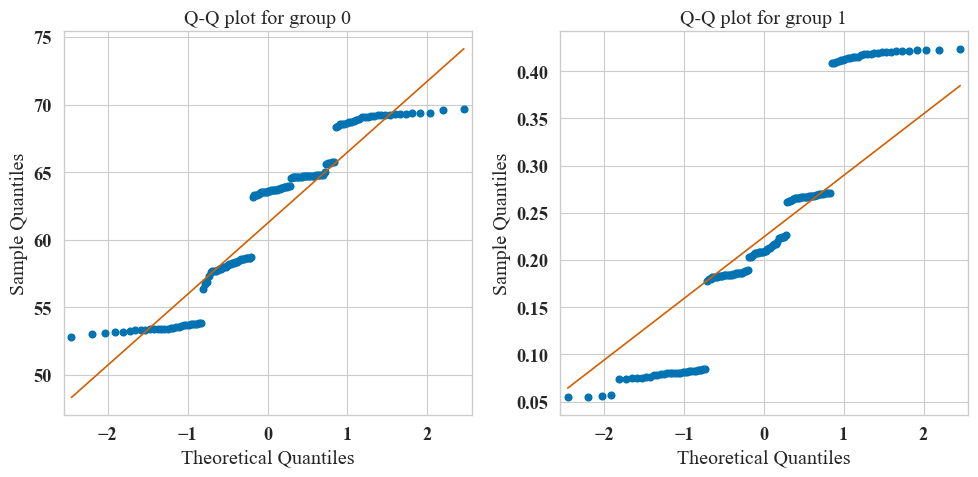

In [8]:
local_ml_df = analysis_df.query("`training environment` == 'Local ML'")
test_assumptions(local_ml_df["temperature"], local_ml_df["energy"], nrows=1, ncols=2, figsize=(10, 5))

The visual assessment and the Shapiro-Wilk test indicate that the data is not normally distributed. Therefore, we perform the Spearman's rank correlation test.


#### Spearman's rank correlation test

The results of the correlation test show that there is a positive correlation between temperature and energy consumption. However, we observe different behaviors depending on the environment.


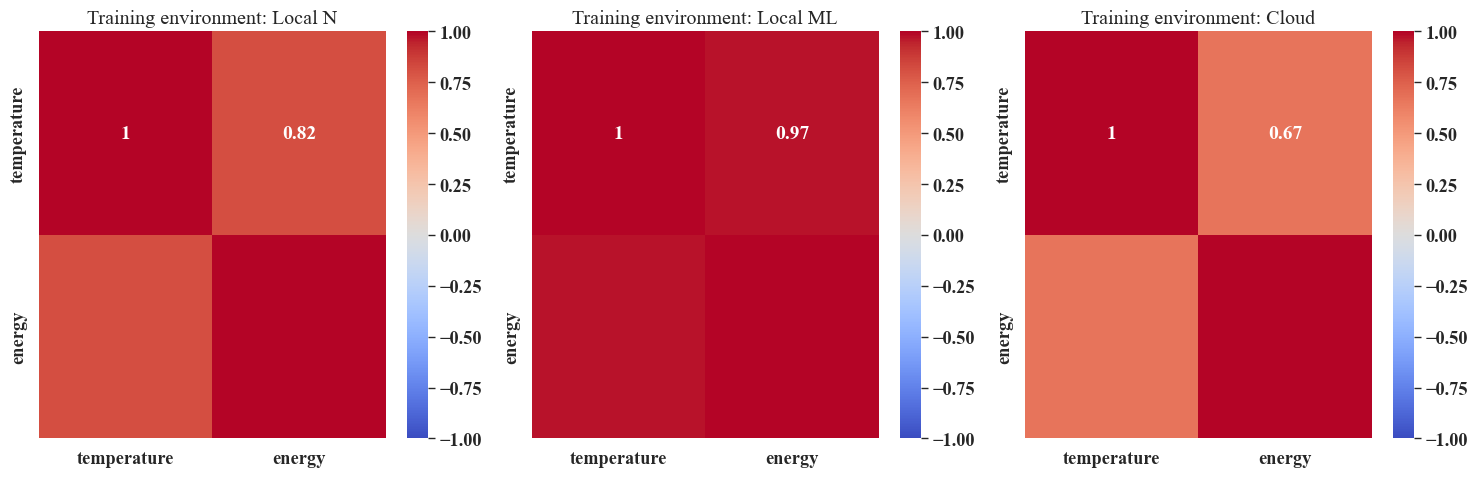

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, strategy in enumerate(TRAIN_STRATEGIES):
    data = analysis_df.query("`training environment` == @strategy")[["temperature", "energy"]]

    corr = data.corr("spearman")
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=axes[i], cmap="coolwarm")
    ax.set_title(f"Training environment: {strategy}")

if SAVE_FIGS:
    plt.savefig(os.path.join(SAVE_FIGS_DIR, f"temperature-energy-correlation.{FIGURES_FORMAT}"))

### Impact of temperature on GPU usage

As with the energy consumption, we do not observe a particular correlation between temperature and GPU usage in a general view. However, when looking at the data for each environment separately, we there seems to be a positive correlation between temperature and GPU usage.


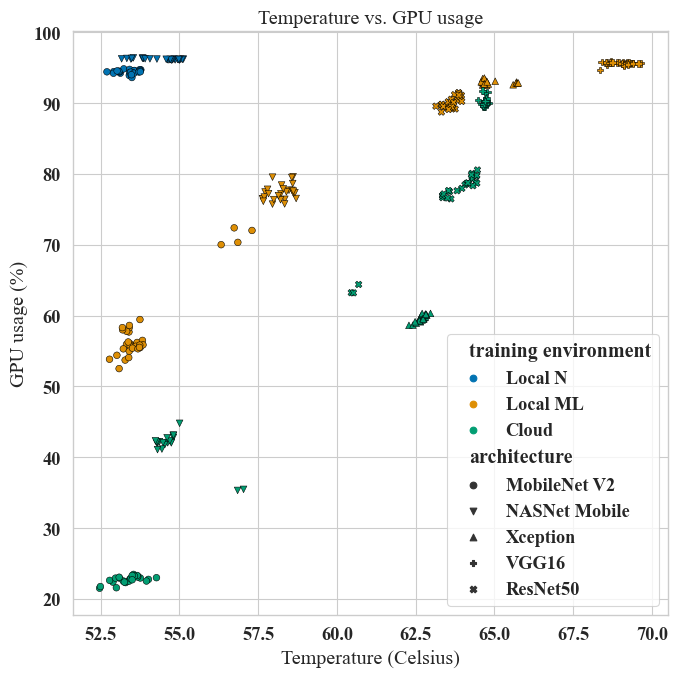

In [10]:
_, axes = plt.subplots(1, 1, figsize=((7, 7)))
ax = sns.scatterplot(
    analysis_df,
    x="temperature",
    y="gpu_usage",
    ax=axes,
    style="architecture",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    markers=MARKERS,
    edgecolor="black",
)
ax.set_title("Temperature vs. GPU usage")
ax.set_xlabel("Temperature (Celsius)")
ax.set_ylabel("GPU usage (%)")

if SAVE_FIGS:
    plt.savefig(os.path.join(SAVE_FIGS_DIR, f"temperature-gpu_usage-scatter.{FIGURES_FORMAT}"))

plt.show()

#### Test normality assumption

As in the previous correlation analysis, we check the normality of the data.


Shapiro test for normality of group 0: W = 0.7648234367370605 and p-value 4.820462605470421e-13. Is normaly distributed? False
Shapiro test for normality of group 1: W = 0.8858290910720825 and p-value 1.7846884858840895e-08. Is normaly distributed? False
Levene test for equal variances: W = 191.26939986308972 and p-value = 8.301180282407208e-33. Equal variances? False


([ShapiroResult(statistic=0.7648234367370605, pvalue=4.820462605470421e-13),
  ShapiroResult(statistic=0.8858290910720825, pvalue=1.7846884858840895e-08)],
 LeveneResult(statistic=191.26939986308972, pvalue=8.301180282407208e-33))

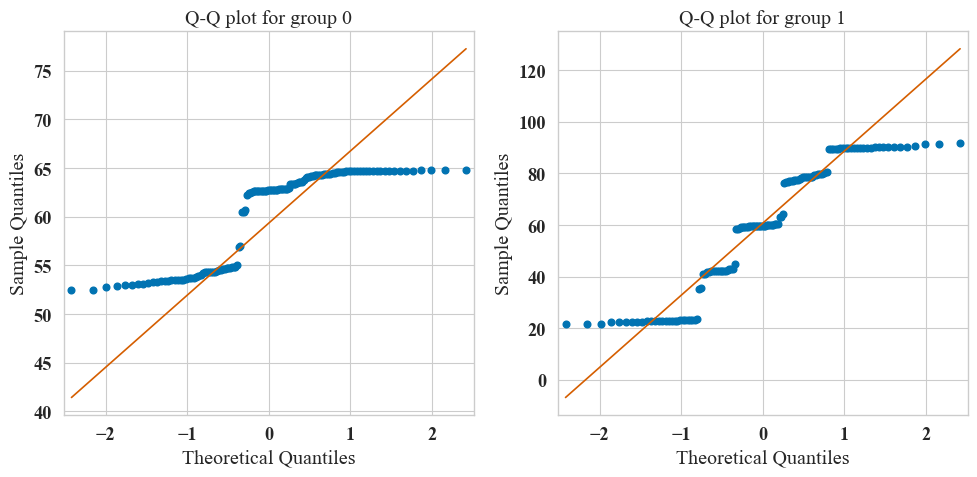

In [11]:
cloud_df = analysis_df.query("`training environment` == 'Cloud'")
test_assumptions(cloud_df["temperature"], cloud_df["gpu_usage"], nrows=1, ncols=2, figsize=(10, 5))

Shapiro test for normality of group 0: W = 0.9073910713195801 and p-value 0.000514488376211375. Is normaly distributed? False
Shapiro test for normality of group 1: W = 0.7943481802940369 and p-value 2.994050305460405e-07. Is normaly distributed? False
Levene test for equal variances: W = 24.177873559447843 and p-value = 3.2241560339944036e-06. Equal variances? False


([ShapiroResult(statistic=0.9073910713195801, pvalue=0.000514488376211375),
  ShapiroResult(statistic=0.7943481802940369, pvalue=2.994050305460405e-07)],
 LeveneResult(statistic=24.177873559447843, pvalue=3.2241560339944036e-06))

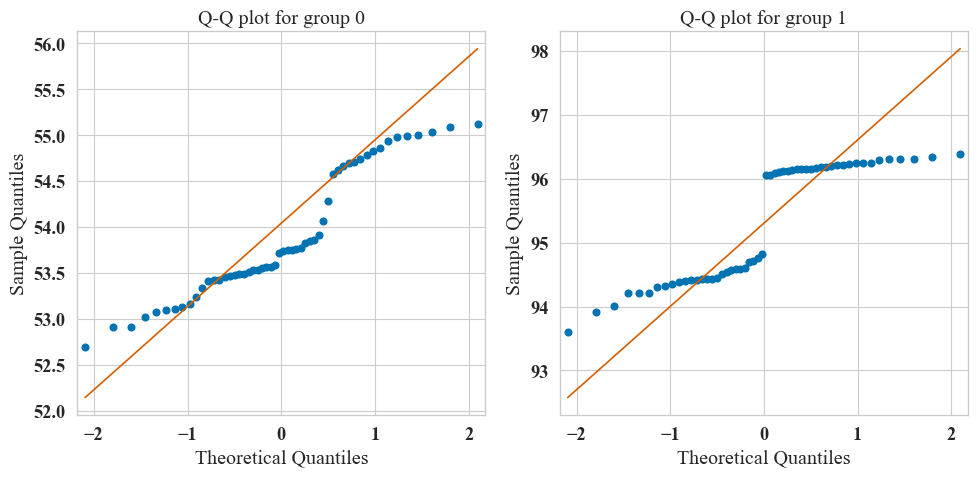

In [12]:
local_n_df = analysis_df.query("`training environment` == 'Local N'")
test_assumptions(local_n_df["temperature"], local_n_df["gpu_usage"], nrows=1, ncols=2, figsize=(10, 5))

Shapiro test for normality of group 0: W = 0.9073910713195801 and p-value 0.000514488376211375. Is normaly distributed? False
Shapiro test for normality of group 1: W = 0.7943481802940369 and p-value 2.994050305460405e-07. Is normaly distributed? False
Levene test for equal variances: W = 24.177873559447843 and p-value = 3.2241560339944036e-06. Equal variances? False


([ShapiroResult(statistic=0.9073910713195801, pvalue=0.000514488376211375),
  ShapiroResult(statistic=0.7943481802940369, pvalue=2.994050305460405e-07)],
 LeveneResult(statistic=24.177873559447843, pvalue=3.2241560339944036e-06))

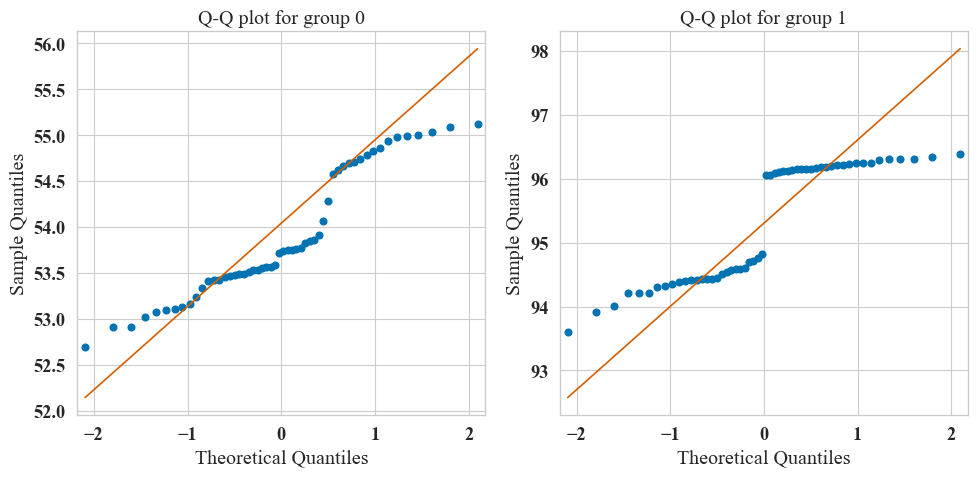

In [13]:
local_ml_df = analysis_df.query("`training environment` == 'Local ML'")
test_assumptions(local_n_df["temperature"], local_n_df["gpu_usage"], nrows=1, ncols=2, figsize=(10, 5))

The visual assessment and the Shapiro-Wilk test indicate that the data is not normally distributed. Therefore, we perform the Spearman's rank correlation test.


#### Spearman's rank correlation test

The results of the correlation test show that there is a positive correlation between temperature and energy consumption. Moreover, we find a very strong correlation between temperature and GPU usage in the Local ML and Cloud environments.


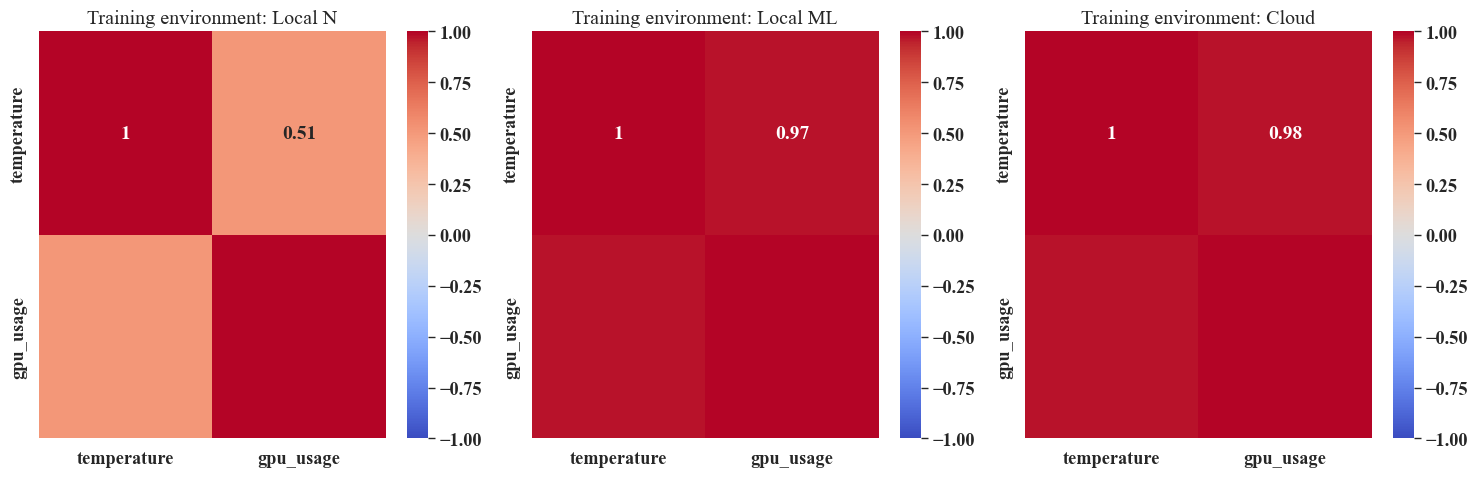

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, strategy in enumerate(TRAIN_STRATEGIES):
    data = analysis_df.query("`training environment` == @strategy")[["temperature", "gpu_usage"]]
    corr = data.corr("spearman")
    # print(strategy)
    # print(corr, end="\n\n")
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=axes[i], cmap="coolwarm")
    ax.set_title(f"Training environment: {strategy}")

if SAVE_FIGS:
    plt.savefig(os.path.join(SAVE_FIGS_DIR, f"temperature-gpu_usage-correlation.{FIGURES_FORMAT}"))

### Comparison between model architectures and training environment

#### Energy comparison


In [15]:
analysis_df_no_outliers = analysis_df.sort_values(
    by=["GFLOPs", "training environment", "architecture"], ascending=True
).reset_index(drop=True)

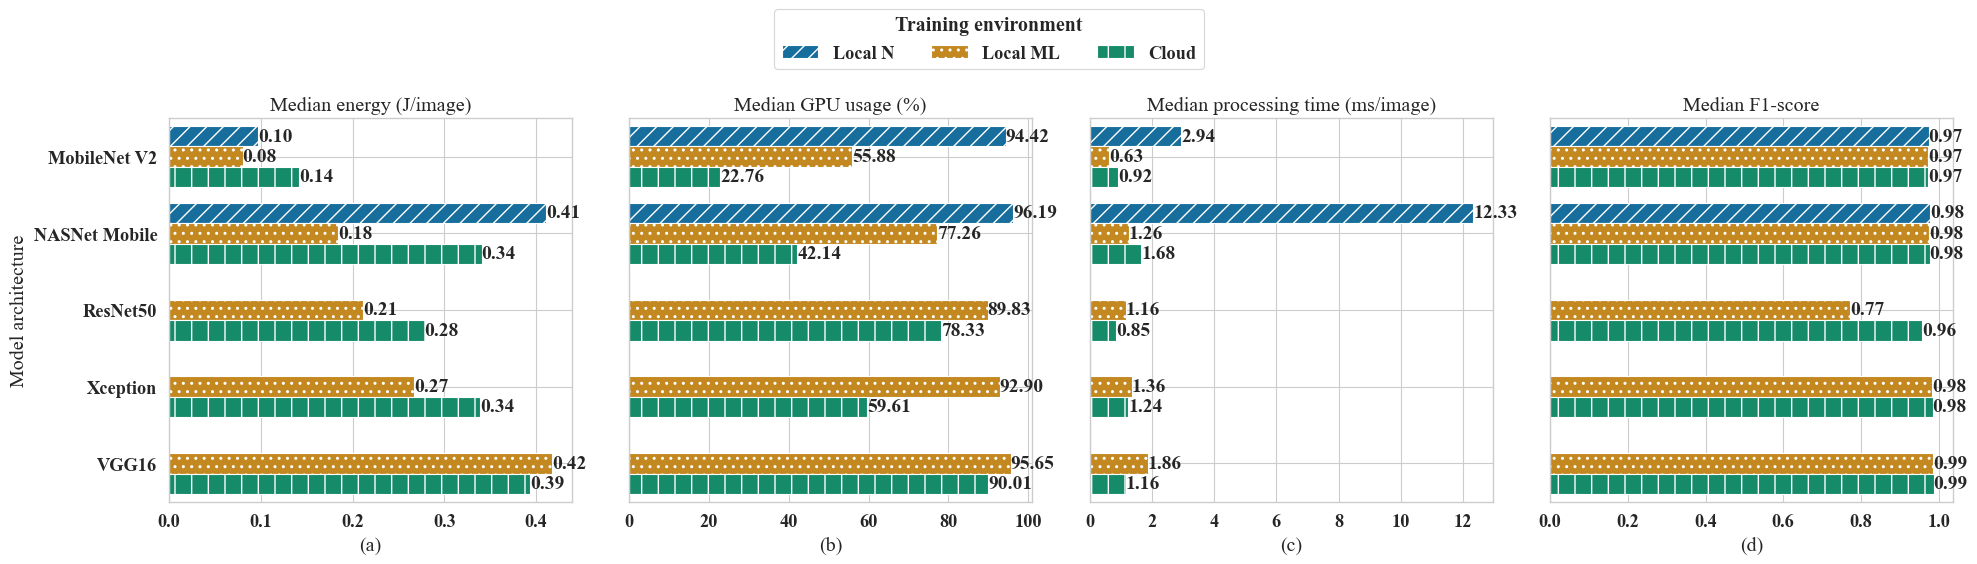

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5), sharey=True)


def set_hatches(axis):
    hatches = ["//", "..", "|"]
    for i, bar in enumerate(axis.patches):
        bar.set_hatch(hatches[i // 5 % len(hatches)])


# Create bar plots
_, ax1 = barplot(
    data=analysis_df_no_outliers,
    x="energy",
    y="architecture",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    ylabel="Model architecture",
    xlabel="(a)",
    barlabel=True,
    ax=ax1,
)
ax1.set_title("Median energy (J/image)")
set_hatches(ax1)

_, ax2 = barplot(
    data=analysis_df_no_outliers,
    x="gpu_usage",
    y="architecture",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    xlabel="(b)",
    barlabel=True,
    ax=ax2,
)
ax2.set_title("Median GPU usage (%)")
set_hatches(ax2)

_, ax3 = barplot(
    data=analysis_df_no_outliers,
    x="normalized duration",
    y="architecture",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    xlabel="(c)",
    estimator="median",
    barlabel=True,
    ax=ax3,
)
ax3.set_title("Median processing time (ms/image)")
set_hatches(ax3)

_, ax4 = barplot(
    data=analysis_df_no_outliers,
    x="f1-score",
    y="architecture",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    xlabel="(d)",
    barlabel=True,
    ax=ax4,
)
ax4.set_title("Median F1-score")
set_hatches(ax4)


# Place the legend in the upper center of the figure
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title="Training environment", loc="upper center", ncols=3, bbox_to_anchor=(0.5, 1.15))

ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()

if SAVE_FIGS:
    plt.savefig(os.path.join(SAVE_FIGS_DIR, f"full-metrics-comparison.{FIGURES_FORMAT}"), bbox_inches="tight")

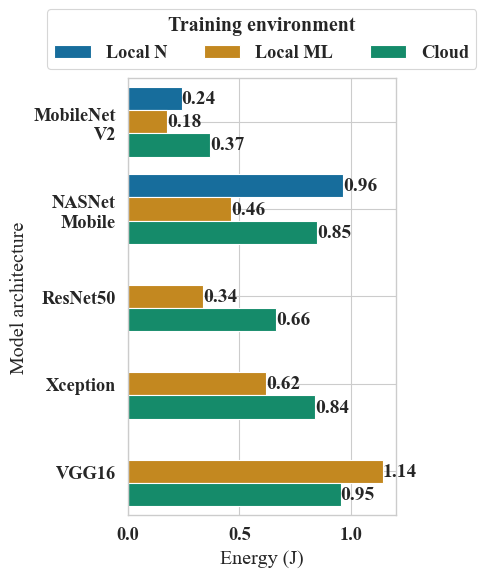

In [17]:
_, ax = barplot(
    analysis_df_no_outliers,
    x="raw energy",
    y="architecture",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    xlabel="Energy (J)",
    ylabel="Model architecture",
    barlabel=True,
    figsize=(5, 6),
)
ax.legend(title="Training environment", loc="lower center", bbox_to_anchor=(0.5, 1), ncols=3)
labels = [label.get_text().replace(" ", "\n") for label in ax.get_yticklabels()]
ax.set_yticklabels(labels)

plt.savefig(os.path.join(SAVE_FIGS_DIR, f"raw-energy-comparison-full.{FIGURES_FORMAT}"))

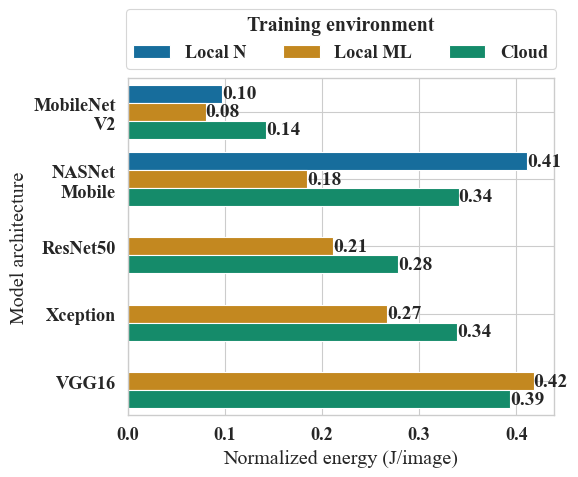

In [18]:
_, ax = barplot(
    analysis_df_no_outliers,
    y="architecture",
    x="energy",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    ylabel="Model architecture",
    xlabel="Normalized energy (J/image)",
    barlabel=True,
    figsize=(6, 5),
)
ax.legend(title="Training environment", loc="lower center", bbox_to_anchor=(0.5, 1), ncols=3)

labels = [label.get_text().replace(" ", "\n") for label in ax.get_yticklabels()]
ax.set_yticklabels(labels)

plt.savefig(os.path.join(SAVE_FIGS_DIR, f"energy-comparison-full.{FIGURES_FORMAT}"))

##### Energy improvement within architectures


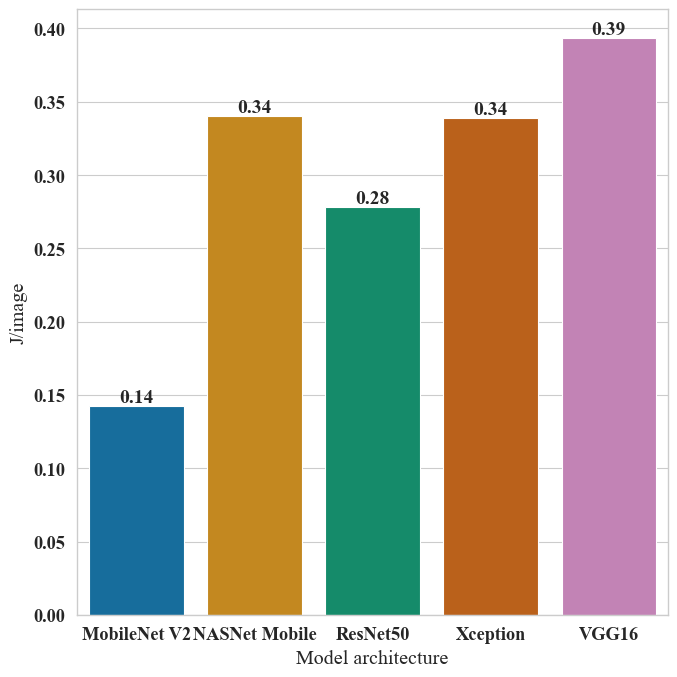

In [19]:
_, ax1 = plt.subplots(1, 1, figsize=((7, 7)))
_, ax = barplot(
    analysis_df_no_outliers.query("`training environment` == 'Cloud'"),
    x="architecture",
    y="energy",
    estimator="median",
    xlabel="Model architecture",
    ylabel="J/image",
    barlabel=True,
    ax=ax1,
)

plt.savefig(os.path.join(SAVE_FIGS_DIR, f"energy-comparison-cloud.{FIGURES_FORMAT}"))

In [20]:
improvement = (cloud_vgg16.energy.median() - cloud_mobilenet.energy.median()) / cloud_vgg16.energy.median()
print(f"Maximum improvement: {improvement}")

Maximum improvement: 0.6385643239116962


In [21]:
improvement = (cloud_vgg16.energy.median() - cloud_xception.energy.median()) / cloud_vgg16.energy.median()
print(f"Minimum improvement: {improvement}")

Minimum improvement: 0.1392719683507018


##### Energy improvement within training strategies


In [22]:
improvement = (cloud_mobilenet.energy.median() - local_ml_mobilenet.energy.median()) / cloud_mobilenet.energy.median()
print(f"Maximum improvement: {improvement}")

Maximum improvement: 0.43595018745848907


In [23]:
improvement = (cloud_mobilenet.energy.median() - local_n_mobilenet.energy.median()) / cloud_mobilenet.energy.median()
print(f"Minimum improvement: {improvement}")

Minimum improvement: 0.31607176445346896


##### Overall energy improvement


In [24]:
print_improvement(analysis_df_no_outliers, "energy")

Maximum improvement: 0.8078981269323078 (VGG16 - Local ML, MobileNet V2 - Local ML)
Minimum improvement: 0.005368234515320405 (NASNet Mobile - Cloud, Xception - Cloud)


In [25]:
for index, training_environment in analysis_df_no_outliers.groupby("training environment"):
    median_energy = training_environment.groupby("architecture")["energy"].median()
    # Compute the percentage of maximum energy reduction
    max_energy = median_energy.max()
    median_energy = 100 - median_energy / max_energy * 100
    print(f"Median energy reduction for {index}:")
    print(median_energy, end="\n\n")

Median energy reduction for Cloud:
architecture
MobileNet V2     63.856432
NASNet Mobile    13.462644
ResNet50         29.254050
VGG16             0.000000
Xception         13.927197
Name: energy, dtype: float64

Median energy reduction for Local ML:
architecture
MobileNet V2     80.789813
NASNet Mobile    55.873648
ResNet50         49.369128
VGG16             0.000000
Xception         36.103568
Name: energy, dtype: float64

Median energy reduction for Local N:
architecture
MobileNet V2     76.331897
NASNet Mobile     0.000000
Name: energy, dtype: float64



#### GPU usage comparison


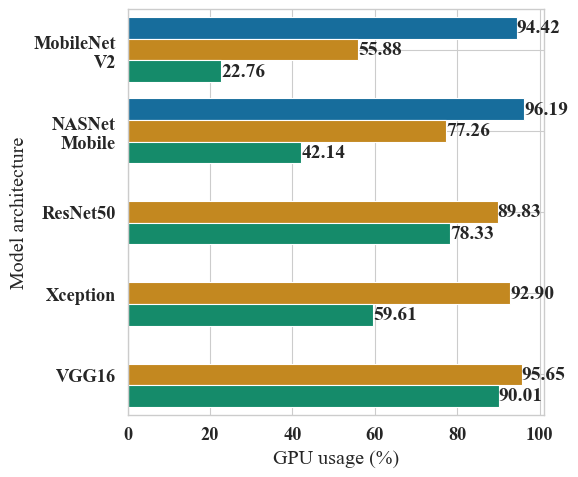

In [26]:
_, ax = barplot(
    analysis_df_no_outliers,
    y="architecture",
    x="gpu_usage",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    ylabel="Model architecture",
    xlabel="GPU usage (%)",
    barlabel=True,
    figsize=(6, 5),
)

labels = [label.get_text().replace(" ", "\n") for label in ax.get_yticklabels()]
ax.set_yticklabels(labels)

ax.get_legend().remove()
plt.savefig(os.path.join(SAVE_FIGS_DIR, f"gpu-comparison-full.{FIGURES_FORMAT}"))

#### GPU usage comparison within architectures


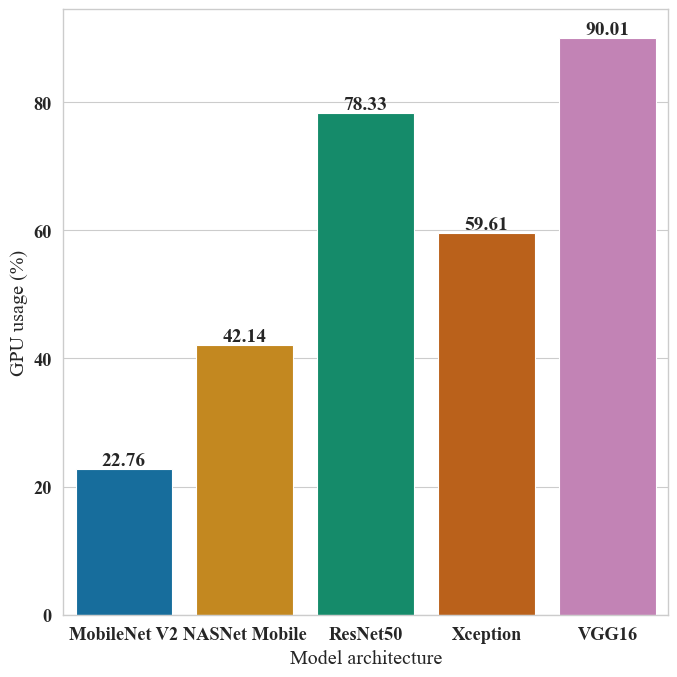

In [27]:
_, ax1 = plt.subplots(1, 1, figsize=((7, 7)))
_, ax = barplot(
    analysis_df_no_outliers.query("`training environment` == 'Cloud'"),
    x="architecture",
    y="gpu_usage",
    estimator="median",
    xlabel="Model architecture",
    ylabel="GPU usage (%)",
    barlabel=True,
    ax=ax1,
)

plt.savefig(os.path.join(SAVE_FIGS_DIR, f"gpu-comparison-cloud.{FIGURES_FORMAT}"))

#### Training time comparison


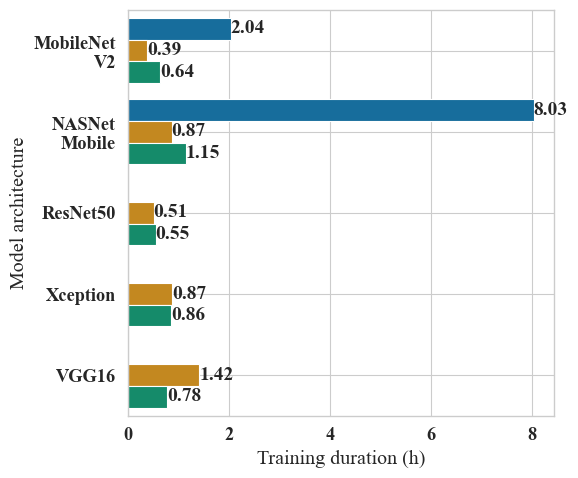

In [28]:
_, ax = barplot(
    analysis_df_no_outliers,
    y="architecture",
    x="training duration (h)",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    ylabel="Model architecture",
    xlabel="Training duration (h)",
    barlabel=True,
    figsize=(6, 5),
)

labels = [label.get_text().replace(" ", "\n") for label in ax.get_yticklabels()]
ax.set_yticklabels(labels)

ax.get_legend().remove()

if SAVE_FIGS:
    plt.savefig(os.path.join(SAVE_FIGS_DIR, f"raw-training-time-comparison-full.{FIGURES_FORMAT}"))

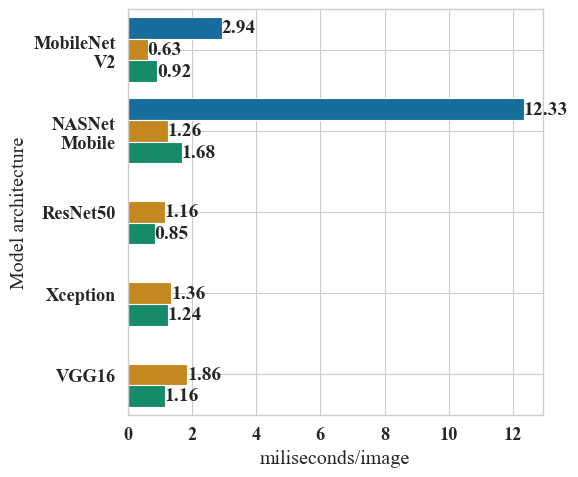

In [29]:
_, ax = barplot(
    analysis_df_no_outliers,
    y="architecture",
    x="normalized duration",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    ylabel="Model architecture",
    xlabel="miliseconds/image",
    barlabel=True,
    figsize=(6, 5),
)

labels = [label.get_text().replace(" ", "\n") for label in ax.get_yticklabels()]
ax.set_yticklabels(labels)

ax.get_legend().remove()

if SAVE_FIGS:
    plt.savefig(os.path.join(SAVE_FIGS_DIR, f"training-time-comparison-full.{FIGURES_FORMAT}"))

#### Training time comparison within architectures


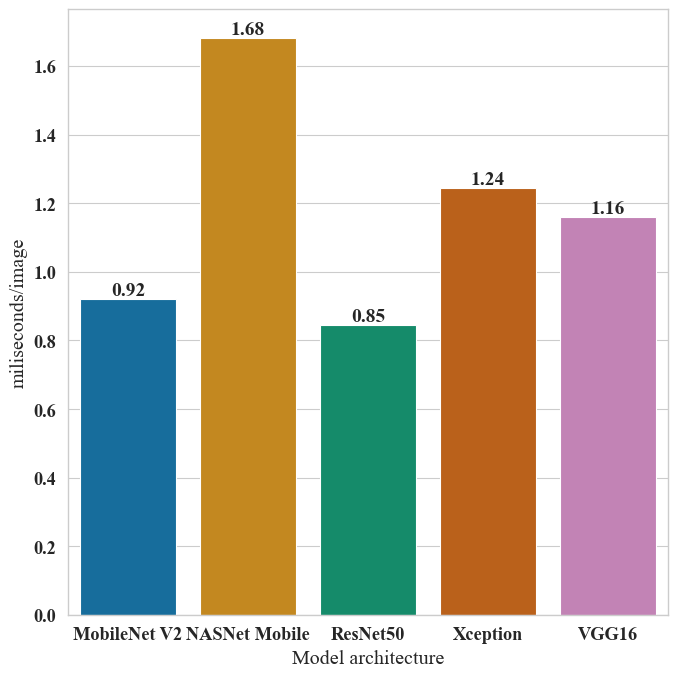

In [30]:
_, ax = barplot(
    analysis_df_no_outliers.query("`training environment` == 'Cloud'"),
    x="architecture",
    y="normalized duration",
    estimator="median",
    xlabel="Model architecture",
    ylabel="miliseconds/image",
    barlabel=True,
    figsize=(7, 7),
)

if SAVE_FIGS:
    plt.savefig(os.path.join(SAVE_FIGS_DIR, f"training-time-comparison-cloud.{FIGURES_FORMAT}"))

#### GPU power comparison


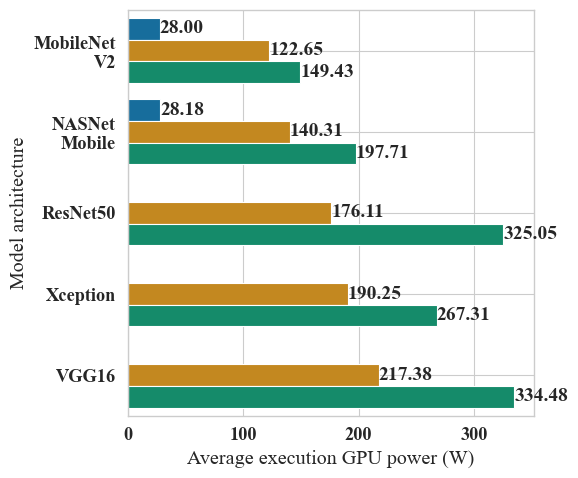

In [31]:
_, ax = barplot(
    analysis_df_no_outliers,
    y="architecture",
    x="average gpu power (W)",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    ylabel="Model architecture",
    xlabel="Average execution GPU power (W)",
    barlabel=True,
    figsize=(6, 5),
)

labels = [label.get_text().replace(" ", "\n") for label in ax.get_yticklabels()]
ax.set_yticklabels(labels)

ax.get_legend().remove()

if SAVE_FIGS:
    plt.savefig(os.path.join(SAVE_FIGS_DIR, f"raw-training-time-comparison-full.{FIGURES_FORMAT}"))

#### $F_1$ score comparison


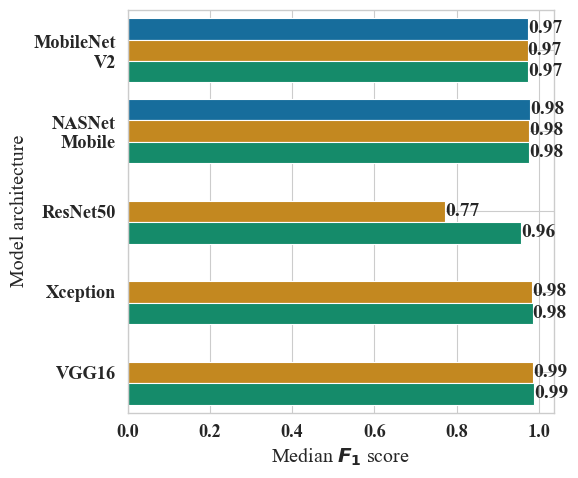

In [32]:
_, ax = barplot(
    analysis_df_no_outliers,
    y="architecture",
    x="f1-score",
    ylabel="Model architecture",
    xlabel="Median $F_1$ score",
    estimator="median",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    barlabel=True,
    figsize=(6, 5),
)

ax.get_legend().remove()
labels = [label.get_text().replace(" ", "\n") for label in ax.get_yticklabels()]
ax.set_yticklabels(labels)

if SAVE_FIGS:
    plt.savefig(os.path.join(SAVE_FIGS_DIR, f"accuracy-comparison.{FIGURES_FORMAT}"))

##### $F_1$ score improvement within architectures


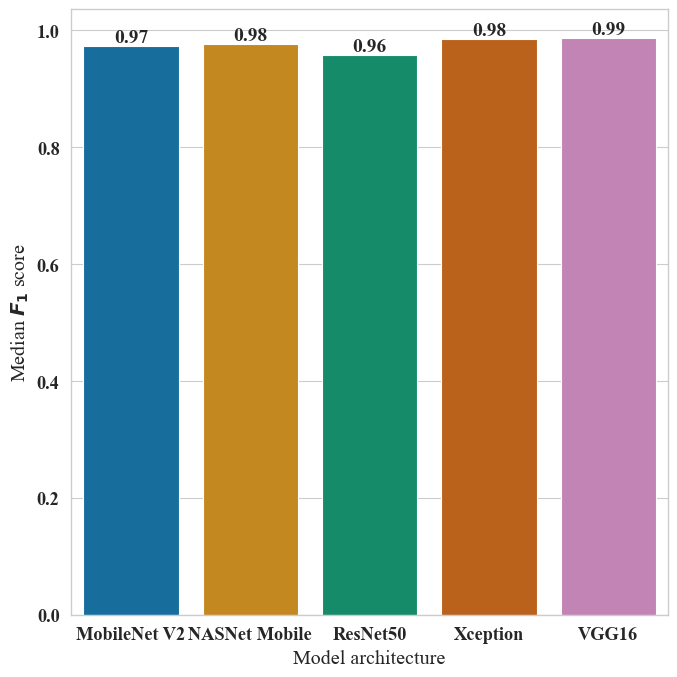

In [33]:
_, ax = barplot(
    analysis_df_no_outliers.query("`training environment` == 'Cloud'"),
    x="architecture",
    y="f1-score",
    xlabel="Model architecture",
    ylabel="Median $F_1$ score",
    estimator="median",
    barlabel=True,
    figname=f"cloud-f1score-comparison.{FIGURES_FORMAT}",
    figsize=(7, 7),
)

In [34]:
improvement = (cloud_vgg16["f1-score"].median() - cloud_resnet50["f1-score"].median()) / cloud_vgg16[
    "f1-score"
].median()
print(f"Maximum improvement: {improvement}")
1 - improvement

Maximum improvement: 0.030557545836576758


0.9694424541634232

In [35]:
improvement = (cloud_vgg16["f1-score"].median() - cloud_xception["f1-score"].median()) / cloud_vgg16[
    "f1-score"
].median()
print(f"Minimum improvement: {improvement}")
1 - improvement

Minimum improvement: 0.0026348967418301076


0.9973651032581698

##### Overall $F_1$ score improvement


In [36]:
print_improvement(analysis_df_no_outliers, "f1-score")

Maximum improvement: 0.21887229244141496 (VGG16 - Cloud, ResNet50 - Local ML)
Minimum improvement: 0.0007216690171848206 (MobileNet V2 - Cloud, MobileNet V2 - Local ML)


### Trade-off between accuracy and energy


/home/santiago/.cache/pypoetry/virtualenvs/seaa2023-ect-extension-5MNfinQm-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/santiago/.cache/pypoetry/virtualenvs/seaa2023-ect-extension-5MNfinQm-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/santiago/.cache/pypoetry/virtualenvs/seaa2023-ect-extension-5MNfinQm-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True)

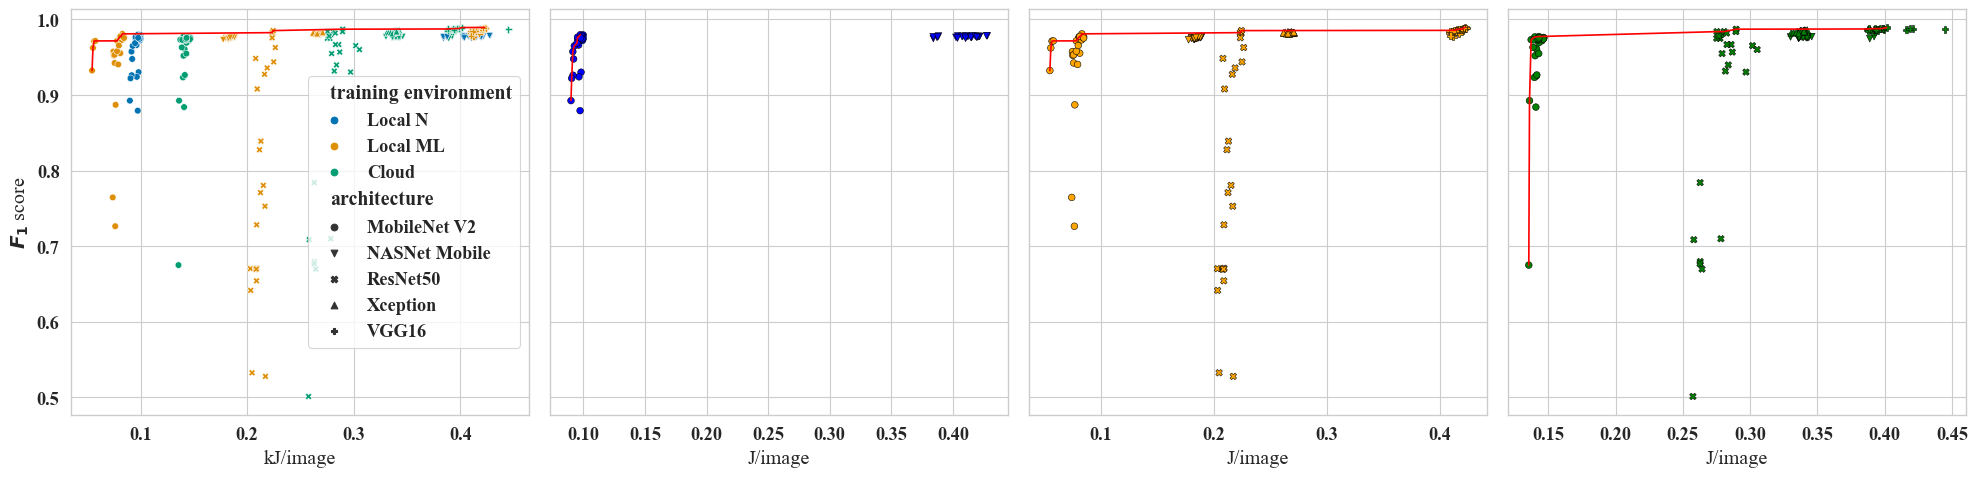

In [37]:
_, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

colors = {"Cloud": "green", "Local N": "blue", "Local ML": "orange"}

tradeoff_data = analysis_df_no_outliers.query("`f1-score` >= 0.5")
costs = tradeoff_data[["energy", "f1-score"]].to_numpy()
pareto = is_pareto_efficient(costs)
sns.scatterplot(
    tradeoff_data,
    x="energy",
    y="f1-score",
    style="architecture",
    markers=MARKERS,
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    ax=axes[0],
)
sns.lineplot(tradeoff_data.loc[pareto], x="energy", y="f1-score", ax=axes[0], color="red")
axes[0].grid(visible=True, axis="both")

axes[0].set_xlabel("kJ/image")
axes[0].set_ylabel("$F_1$ score")

for i, strategy in enumerate(TRAIN_STRATEGIES, 1):
    data = tradeoff_data.query("`training environment` == @strategy")
    costs = data[["energy", "f1-score"]].to_numpy()
    pareto = is_pareto_efficient(costs)
    sns.scatterplot(
        data,
        x="energy",
        y="f1-score",
        style="architecture",
        markers=MARKERS,
        color=colors[strategy],
        ax=axes[i],
        edgecolor="black",
    )
    sns.lineplot(data.loc[pareto], x="energy", y="f1-score", ax=axes[i], color="red")

    axes[i].get_legend().remove()
    axes[i].set_xlabel("J/image")

    axes[i].grid(visible=True, axis="both")


if SAVE_FIGS:
    plt.savefig(os.path.join(SAVE_FIGS_DIR, f"accuracy-energy-comparison.{FIGURES_FORMAT}"))

/home/santiago/.cache/pypoetry/virtualenvs/seaa2023-ect-extension-5MNfinQm-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/santiago/.cache/pypoetry/virtualenvs/seaa2023-ect-extension-5MNfinQm-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


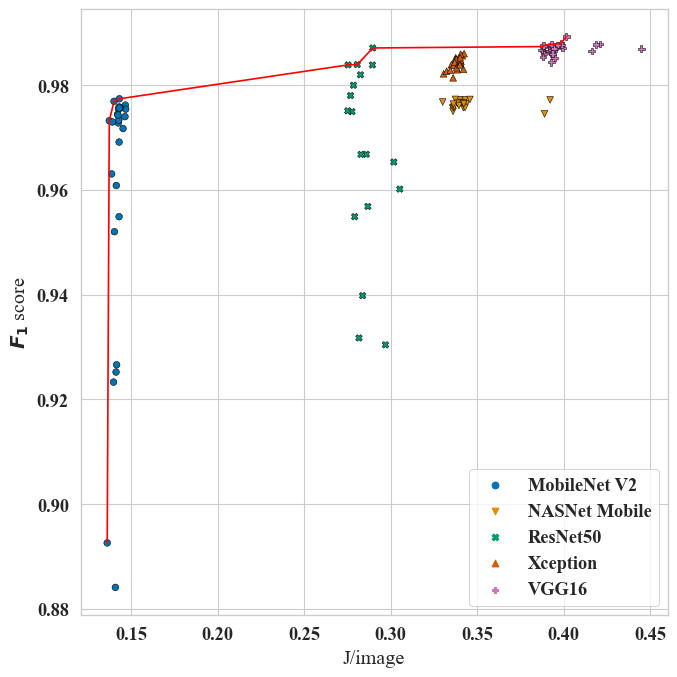

In [38]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))

colors = {"Cloud": "green", "Local N": "blue", "Local ML": "orange"}

tradeoff_data = analysis_df_no_outliers.query("`training environment` == 'Cloud' & `f1-score` >= 0.8")
costs = tradeoff_data[["energy", "f1-score"]].to_numpy()
pareto = is_pareto_efficient(costs)
sns.scatterplot(
    tradeoff_data,
    x="energy",
    y="f1-score",
    style="architecture",
    markers=MARKERS,
    hue="architecture",
    ax=ax,
    edgecolor="black",
)
ax.grid(visible=True, axis="both")

ax.set_xlabel("J/image")
ax.set_ylabel("$F_1$ score")

sns.lineplot(tradeoff_data.loc[pareto], x="energy", y="f1-score", ax=ax, color="red")

if SAVE_FIGS:
    plt.savefig(os.path.join(SAVE_FIGS_DIR, f"accuracy-energy-cloud-comparison.{FIGURES_FORMAT}"))

#### Correlation between $F_1$ score and energy

Looking at the Spearman $\rho$ correlation coefficient, we observe that there is a strong positive correlation between $F_1$ score and energy consumption.


In [39]:
results_df = pd.DataFrame(columns=["training environment", "rho", "p-value"])

for strategy in TRAIN_STRATEGIES:
    data = analysis_df_no_outliers.query("`training environment` == @strategy")
    if not data.empty:
        # print(strategy, architecture)
        corr = stats.spearmanr(data.energy, data["f1-score"], alternative="greater")
        # print(corr)
        # print()
        results_df.loc[len(results_df)] = [strategy, corr[0], corr[1]]
results_df

,training environment,rho,p-value
0,Local N,0.662359,2.447001e-08
1,Local ML,0.707424,3.758249e-23
2,Cloud,0.808351,4.438571e-31


### Energy vs. GPU usage


In [40]:
cloud_energy_vs_gpu_usage_df = pd.concat(
    [
        cloud_mobilenet,
        cloud_nasnet,
        cloud_xception,
        cloud_resnet50,
        cloud_vgg16,
    ]
)
local_n_energy_vs_gpu_usage_df = pd.concat(
    [
        local_n_mobilenet,
        local_n_nasnet,
    ]
)

local_ml_energy_vs_gpu_usage_df = pd.concat(
    [
        local_ml_mobilenet,
        local_ml_nasnet,
        local_ml_xception,
        local_ml_resnet50,
        local_ml_vgg16,
    ]
)

From a general perspective, we do not observe a clear correlation between energy consumption and GPU usage.


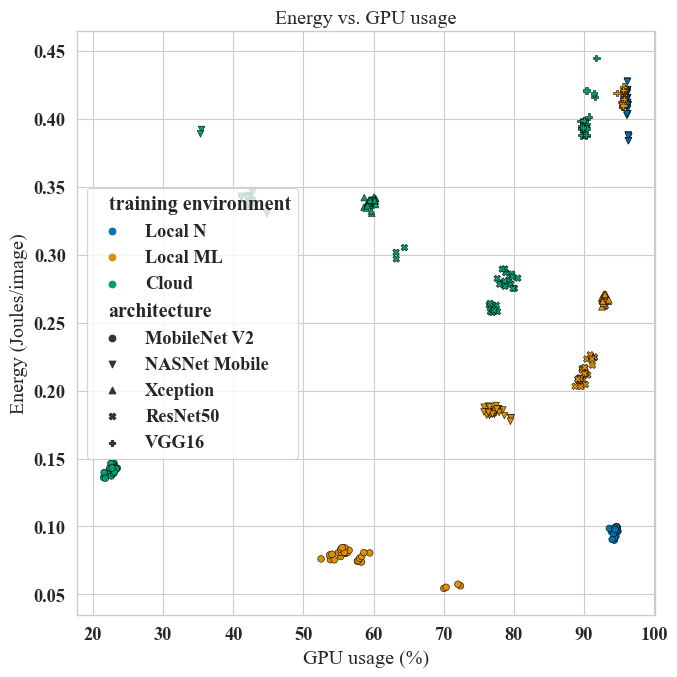

In [41]:
energy_vs_gpu_usage_df = pd.concat(
    [local_n_energy_vs_gpu_usage_df, local_ml_energy_vs_gpu_usage_df, cloud_energy_vs_gpu_usage_df]
)

_, axis = plt.subplots(1, 1, figsize=((7, 7)))
ax = sns.scatterplot(
    energy_vs_gpu_usage_df,
    y="energy",
    x="gpu_usage",
    ax=axis,
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    style="architecture",
    markers=MARKERS,
    legend="brief",
    edgecolor="black",
)
ax.set_title("Energy vs. GPU usage")
ax.set_ylabel("Energy (Joules/image)")
ax.set_xlabel("GPU usage (%)")
plt.show()

#### Correlation between energy and GPU usage


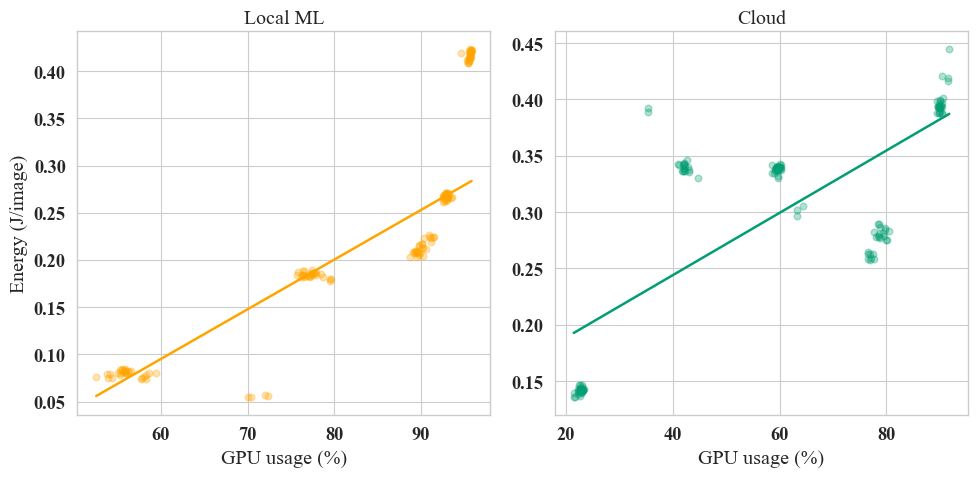

In [42]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
tmp = local_ml_energy_vs_gpu_usage_df.copy()
tmp.energy = local_ml_energy_vs_gpu_usage_df.energy.apply(np.log)
ax = sns.regplot(
    local_ml_energy_vs_gpu_usage_df,
    y="energy",
    x="gpu_usage",
    ax=ax0,
    color=COLORS["Local ML"],
    ci=None,
    robust=True,
    scatter_kws={"alpha": 0.3},
)
ax.set_title("Local ML")
ax.set_ylabel("Energy (J/image)")
ax.set_xlabel("GPU usage (%)")

tmp = cloud_energy_vs_gpu_usage_df.copy()
tmp.energy = cloud_energy_vs_gpu_usage_df.energy.apply(np.log)
ax = sns.regplot(
    cloud_energy_vs_gpu_usage_df,
    y="energy",
    x="gpu_usage",
    ax=ax1,
    color=COLORS["Cloud"],
    ci=None,
    robust=True,
    scatter_kws={"alpha": 0.3},
)
ax.set_title("Cloud")
ax.set_ylabel("")
ax.set_xlabel("GPU usage (%)")

if SAVE_FIGS:
    plt.savefig(os.path.join(SAVE_FIGS_DIR, f"energy-gpu-regression.{FIGURES_FORMAT}"))

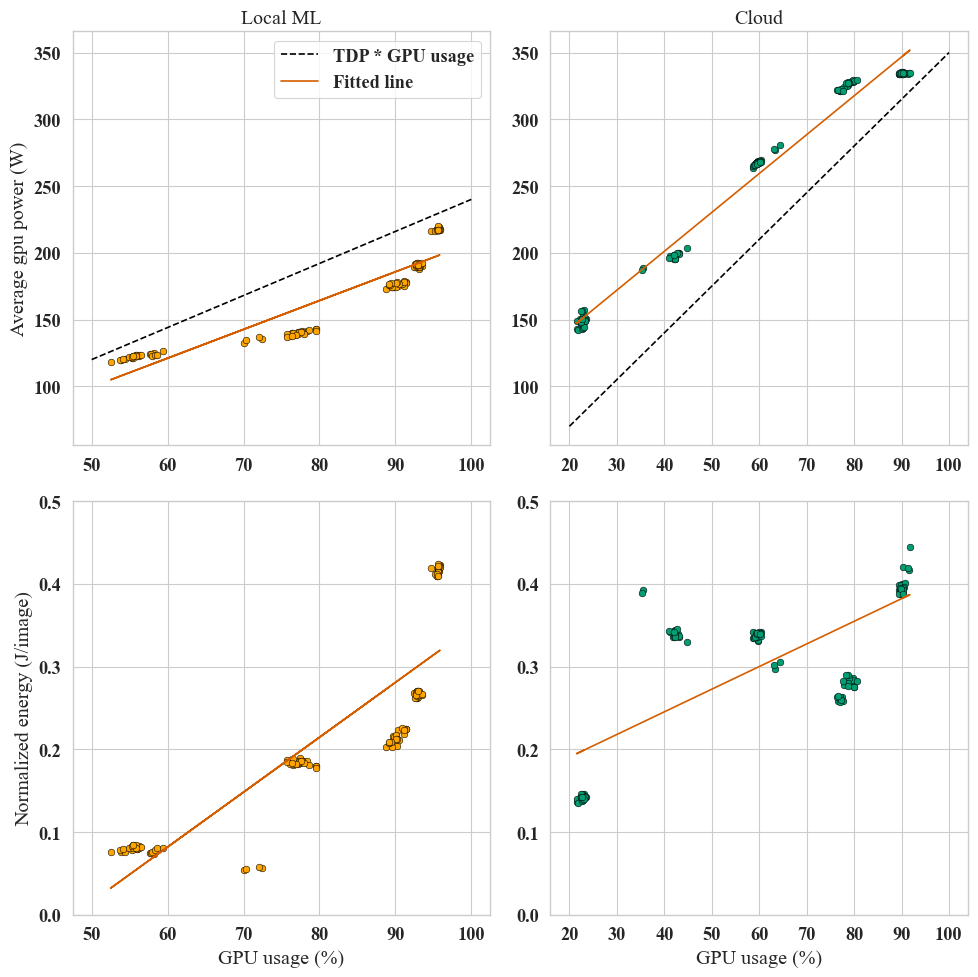

In [121]:
fig = plt.figure(figsize=(10, 10))

tmp = analysis_df.copy()
tmp["label"] = tmp["architecture"] + " - " + tmp["dataset"]

ax1 = plt.subplot(221)
local_ml_data = tmp.query("`training environment` == 'Local ML'")

sns.scatterplot(
    data=local_ml_data,
    x="gpu_usage",
    y="average gpu power (W)",
    ax=ax1,
    color=COLORS["Local ML"],
    edgecolor="black",
)
xx = np.linspace(50, 100)
ax1.plot(
    xx,
    xx / 100 * local_ml_data["max power limit (W)"].iloc[0],
    color="black",
    linestyle="--",
    label="TDP * GPU usage",
)

x, y = local_ml_data["gpu_usage"], local_ml_data["average gpu power (W)"]
res = stats.linregress(x, y)
ax1.plot(x, res.intercept + res.slope * x, "r", label="Fitted line")

ax1.legend()
ax1.set_xlabel("")
ax1.set_ylabel("Average gpu power (W)")

ax1.set_title("Local ML")

ax2 = plt.subplot(222, sharey=ax1)
cloud_data = tmp.query("`training environment` == 'Cloud'")

sns.scatterplot(
    data=cloud_data,
    x="gpu_usage",
    y="average gpu power (W)",
    ax=ax2,
    color=COLORS["Cloud"],
    edgecolor="black",
)

xx = np.linspace(20, 100)
ax2.plot(
    xx,
    xx / 100 * cloud_data["max power limit (W)"].iloc[0],
    color="black",
    linestyle="--",
)

x, y = cloud_data["gpu_usage"], cloud_data["average gpu power (W)"]
res = stats.linregress(x, y)
ax2.plot(x, res.intercept + res.slope * x, "r")
ax2.set_xticks(np.arange(20, 101, 10))
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_title("Cloud")

ax3 = plt.subplot(223, sharex=ax1)
sns.scatterplot(
    data=local_ml_data,
    x="gpu_usage",
    y="energy",
    ax=ax3,
    color=COLORS["Local ML"],
    edgecolor="black",
)

x, y = local_ml_data["gpu_usage"], local_ml_data["energy"]
res = stats.linregress(x, y)
ax3.plot(x, res.intercept + res.slope * x, "r")

ax3.set_xlabel("GPU usage (%)")
ax3.set_ylabel("Normalized energy (J/image)")
ax3.set_ylim(bottom=0, top=0.5)

ax4 = plt.subplot(224, sharex=ax2, sharey=ax3)
sns.scatterplot(
    data=cloud_data,
    x="gpu_usage",
    y="energy",
    ax=ax4,
    color=COLORS["Cloud"],
    edgecolor="black",
)

x, y = cloud_data["gpu_usage"], cloud_data["energy"]
res = stats.linregress(x, y)
ax4.plot(x, res.intercept + res.slope * x, "r")

ax4.set_xlabel("GPU usage (%)")
ax4.set_ylabel("")

if SAVE_FIGS:
    plt.savefig(SAVE_FIGS_DIR / f"effect-of-gpu-usage-on-energy.{FIGURES_FORMAT}", dpi=300, bbox_inches="tight")

##### Corretaltion with Power


In [44]:
stats.spearmanr(
    local_ml_energy_vs_gpu_usage_df["average gpu power (W)"],
    local_ml_energy_vs_gpu_usage_df.gpu_usage,
    alternative="greater",
)

SignificanceResult(statistic=0.9821245580909951, pvalue=9.815959204030748e-104)

In [45]:
stats.spearmanr(
    cloud_energy_vs_gpu_usage_df["average gpu power (W)"],
    cloud_energy_vs_gpu_usage_df.gpu_usage,
    alternative="greater",
)

SignificanceResult(statistic=0.9825066379783921, pvalue=3.827768313772131e-94)

##### Correlation with Energy


In [46]:
stats.spearmanr(
    local_ml_energy_vs_gpu_usage_df.energy,
    local_ml_energy_vs_gpu_usage_df.gpu_usage,
    alternative="greater",
)

SignificanceResult(statistic=0.96454669094765, pvalue=3.522555248695087e-83)

In [47]:
stats.spearmanr(
    cloud_energy_vs_gpu_usage_df.energy,
    cloud_energy_vs_gpu_usage_df.gpu_usage,
    alternative="greater",
)

SignificanceResult(statistic=0.6460984709760117, pvalue=8.938399596978944e-17)

## Statistical significance analysis


### RQ1 - What is the impact of model architecture on a computer vision system with respect to energy efficiency and model correctness?


In [48]:
rq1_df = pd.concat(
    [
        cloud_mobilenet,
        cloud_nasnet,
        cloud_xception,
        cloud_resnet50,
        cloud_vgg16,
    ]
)

#### RQ1.1 - How do DL architectures compare in terms of energy efficiency?

##### Energy

First we test the assumption of normality and homogeneity of the data. After applying a square root transformation to the energy data, we observe that the data is normally distributed. However, the data is not homogenous. Although the Shapiro-Wilk test indicates that the VGG16 data is not normally distributed, seeing the Q-Q plot we consider that the assumption of normality is met. Therefore, we perform a Welch's ANOVA test.


Shapiro test for normality of group 0: W = 0.9595416784286499 and p-value 0.3608037829399109. Is normaly distributed? True
Shapiro test for normality of group 1: W = 0.5738625526428223 and p-value 1.5973427025528508e-06. Is normaly distributed? False
Shapiro test for normality of group 2: W = 0.926862359046936 and p-value 0.057914528995752335. Is normaly distributed? True
Shapiro test for normality of group 3: W = 0.9439828991889954 and p-value 0.1527511328458786. Is normaly distributed? True
Shapiro test for normality of group 4: W = 0.7000036239624023 and p-value 3.877612016367493e-06. Is normaly distributed? False
Levene test for equal variances: W = 4.611970792435288 and p-value = 0.001670068426874333. Equal variances? False


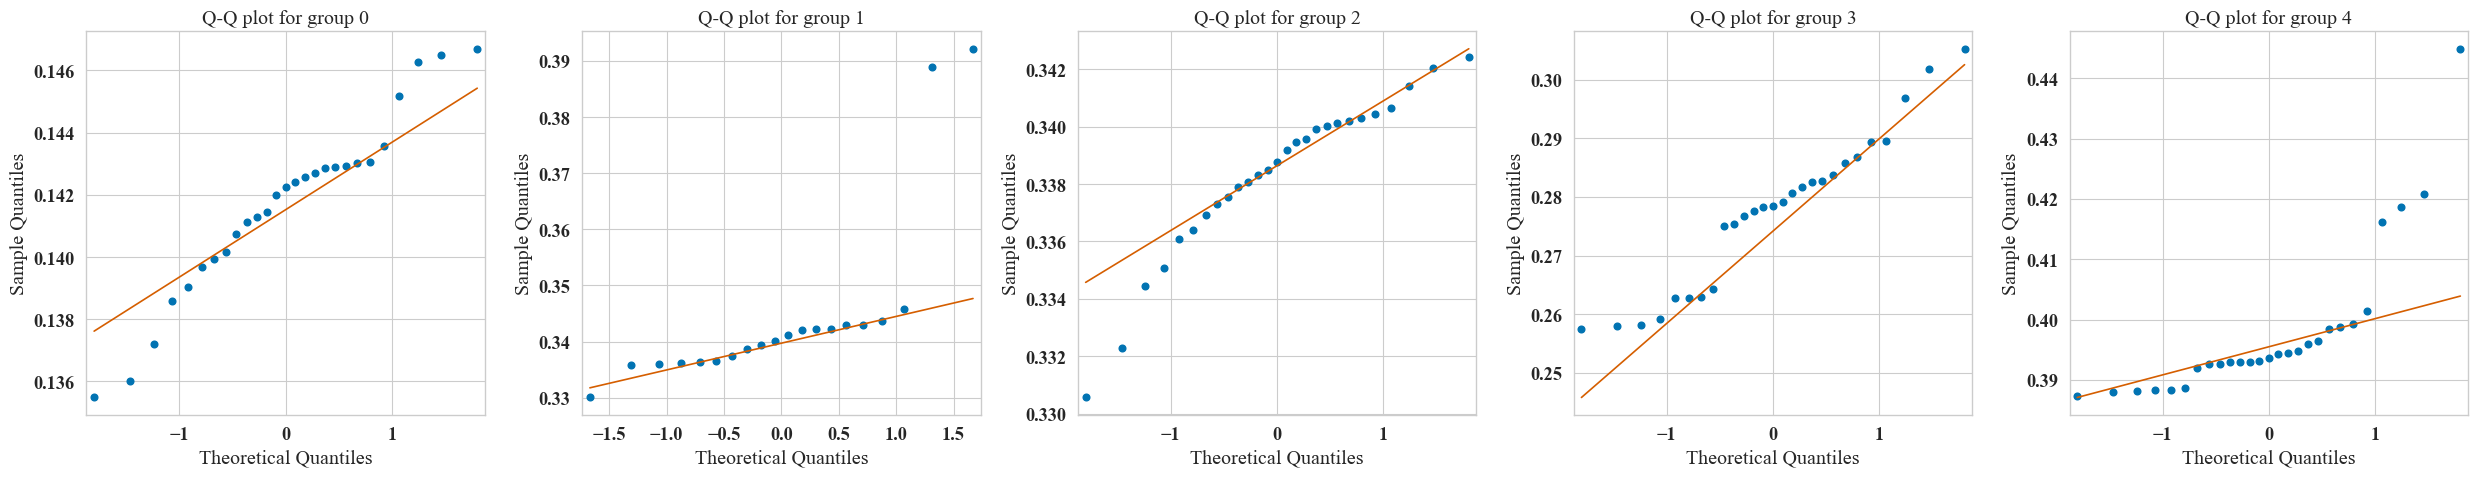

In [49]:
dependent_variable = "energy"
independent_variable = "architecture"

_ = test_assumptions(
    rq1_df.query("architecture == 'MobileNet V2'")[dependent_variable],
    rq1_df.query("architecture == 'NASNet Mobile'")[dependent_variable],
    rq1_df.query("architecture == 'Xception'")[dependent_variable],
    rq1_df.query("architecture == 'ResNet50'")[dependent_variable],
    rq1_df.query("architecture == 'VGG16'")[dependent_variable],
    nrows=1,
    ncols=5,
    figsize=(25, 5),
)

###### Welch's ANOVA test


In [50]:
pg.welch_anova(rq1_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,architecture,4,54.616402,16767.631327,1.205558e-83,0.98624


###### Games-Howell post-hoc test


In [51]:
pg.pairwise_gameshowell(rq1_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,MobileNet V2,NASNet Mobile,0.141688,0.344526,-0.202838,0.003658,-55.457761,19.888383,0.000000e+00,-18.585923
1,MobileNet V2,ResNet50,0.141688,0.277515,-0.135827,0.002626,-51.727324,28.399772,0.000000e+00,-13.874360
2,MobileNet V2,VGG16,0.141688,0.398013,-0.256325,0.002545,-100.714870,28.561401,0.000000e+00,-27.013853
3,MobileNet V2,Xception,0.141688,0.338296,-0.196608,0.000772,-254.573931,51.974854,0.000000e+00,-68.282100
4,NASNet Mobile,ResNet50,0.344526,0.277515,0.067011,0.004434,15.111981,36.252505,0.000000e+00,4.512450
5,NASNet Mobile,VGG16,0.344526,0.398013,-0.053487,0.004387,-12.192236,35.409405,3.015366e-13,-3.658071
6,NASNet Mobile,Xception,0.344526,0.338296,0.006230,0.003656,1.704200,19.850057,4.538813e-01,0.571368
7,ResNet50,VGG16,0.277515,0.398013,-0.120497,0.003572,-33.729215,51.944361,3.996803e-15,-9.046887
8,ResNet50,Xception,0.277515,0.338296,-0.060781,0.002623,-23.169299,28.296888,0.000000e+00,-6.214495
9,VGG16,Xception,0.398013,0.338296,0.059717,0.002542,23.487617,28.451650,0.000000e+00,6.299874


###### Kruskal-Wallis test


In [52]:
result_rq11 = pg.kruskal(rq1_df, dv=dependent_variable, between=independent_variable)
result_rq11

,Source,ddof1,H,p-unc
Kruskal,architecture,4,116.851388,2.511990e-24


###### Eta-squared measure


In [53]:
eta_squared(result_rq11["H"].item(), rq1_df[independent_variable].nunique(), rq1_df.shape[0])

0.917490955634686

###### Dunn's test


In [54]:
p_values = sp.posthoc_dunn(
    rq1_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm", sort=True
)

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,MobileNet V2,NASNet Mobile,ResNet50,VGG16,Xception
MobileNet V2,False,True,True,True,True
NASNet Mobile,True,False,True,True,False
ResNet50,True,True,False,True,True
VGG16,True,True,True,False,True
Xception,True,False,True,True,False


In [55]:
mobilenet_v2 = rq1_df[dependent_variable][rq1_df["architecture"] == "MobileNet V2"]
nasnet_mobile = rq1_df[dependent_variable][rq1_df["architecture"] == "NASNet Mobile"]
xception = rq1_df[dependent_variable][rq1_df["architecture"] == "Xception"]
resnet50 = rq1_df[dependent_variable][rq1_df["architecture"] == "ResNet50"]
vgg16 = rq1_df[dependent_variable][rq1_df["architecture"] == "VGG16"]

print(f"MobileNet V2 - NASNet Mobile effect size: {cliffs_delta(mobilenet_v2, nasnet_mobile)}")
print(f"MobileNet V2 - Xception effect size: {cliffs_delta(mobilenet_v2, xception)}")
print(f"MobileNet V2 - ResNet50 effect size: {cliffs_delta(mobilenet_v2, resnet50)}")
print(f"MobileNet V2 - VGG16 effect size: {cliffs_delta(mobilenet_v2, vgg16)}")
print(f"NASNet Mobile - Xception effect size: {cliffs_delta(nasnet_mobile, xception)}")
print(f"NASNet Mobile - ResNet50 effect size: {cliffs_delta(nasnet_mobile, resnet50)}")
print(f"NASNet Mobile - VGG16 effect size: {cliffs_delta(nasnet_mobile, vgg16)}")
print(f"Xception - ResNet50 effect size: {cliffs_delta(xception, resnet50)}")
print(f"Xception - VGG16 effect size: {cliffs_delta(xception, vgg16)}")
print(f"ResNet50 - VGG16 effect size: {cliffs_delta(resnet50, vgg16)}")

MobileNet V2 - NASNet Mobile effect size: (-1.0, 'large')
MobileNet V2 - Xception effect size: (-1.0, 'large')
MobileNet V2 - ResNet50 effect size: (-1.0, 'large')
MobileNet V2 - VGG16 effect size: (-1.0, 'large')
NASNet Mobile - Xception effect size: (0.26666666666666666, 'small')
NASNet Mobile - ResNet50 effect size: (1.0, 'large')
NASNet Mobile - VGG16 effect size: (-0.9518518518518518, 'large')
Xception - ResNet50 effect size: (1.0, 'large')
Xception - VGG16 effect size: (-1.0, 'large')
ResNet50 - VGG16 effect size: (-1.0, 'large')


##### GPU usage

In this case, we observe that the data is not normally distributed. Therefore, we take the results from the Kruskal-Wallis test as the relevant ones.


Shapiro test for normality of group 0: W = 0.9207553863525391 and p-value 0.04117055982351303. Is normaly distributed? False
Shapiro test for normality of group 1: W = 0.663091778755188 and p-value 1.4296908375399653e-05. Is normaly distributed? False
Shapiro test for normality of group 2: W = 0.956207275390625 and p-value 0.30188319087028503. Is normaly distributed? True
Shapiro test for normality of group 3: W = 0.5985296964645386 and p-value 1.9855166044635553e-07. Is normaly distributed? False
Shapiro test for normality of group 4: W = 0.8274747133255005 and p-value 0.0004258647677488625. Is normaly distributed? False
Levene test for equal variances: W = 4.917853602181824 and p-value = 0.0010333071939050411. Equal variances? False


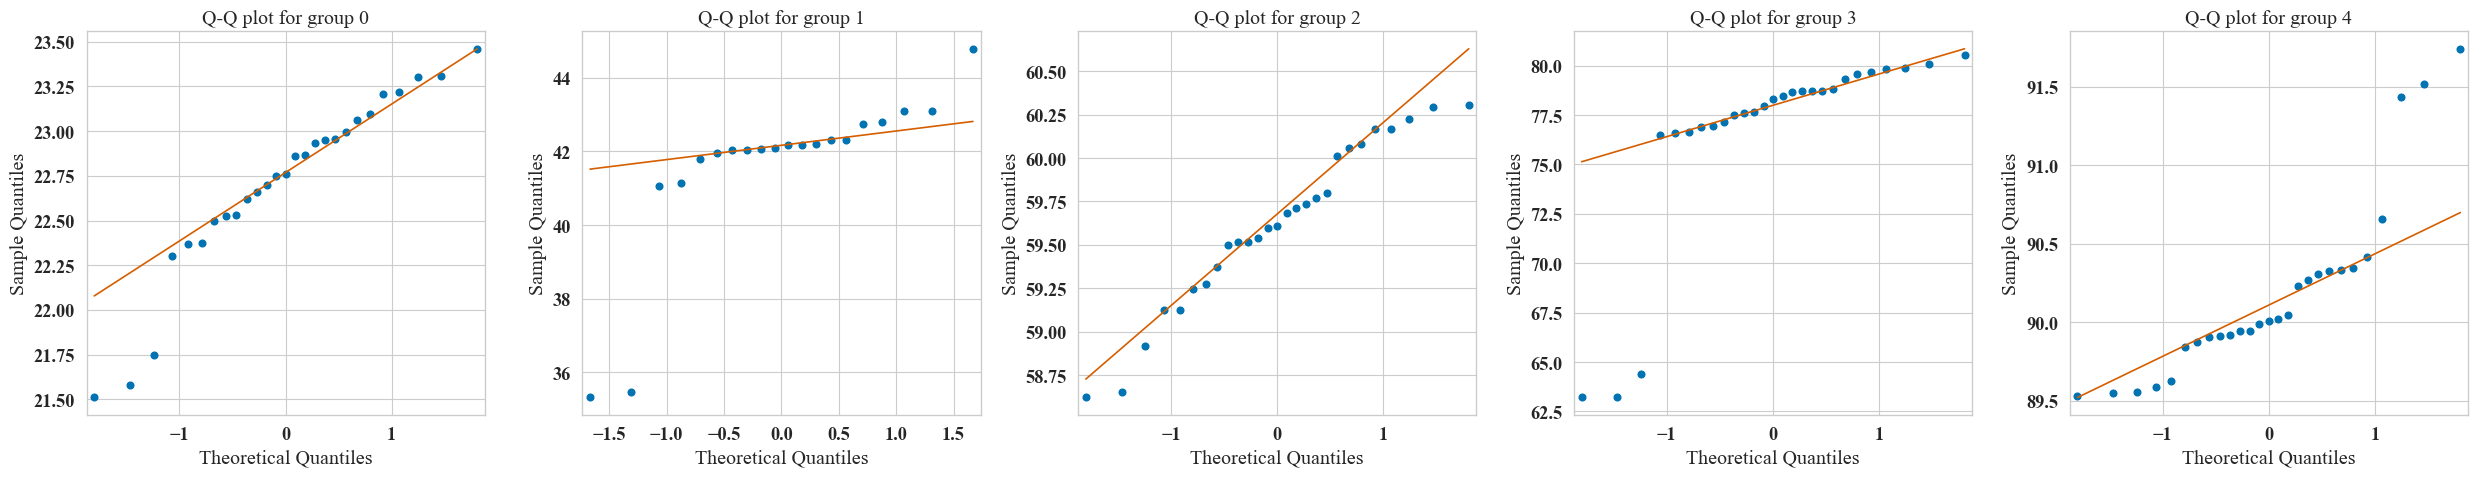

In [56]:
dependent_variable = "gpu_usage"

_ = test_assumptions(
    rq1_df.query("architecture == 'MobileNet V2'")[dependent_variable],
    rq1_df.query("architecture == 'NASNet Mobile'")[dependent_variable],
    rq1_df.query("architecture == 'Xception'")[dependent_variable],
    rq1_df.query("architecture == 'ResNet50'")[dependent_variable],
    rq1_df.query("architecture == 'VGG16'")[dependent_variable],
    nrows=1,
    ncols=5,
    figsize=(25, 5),
)

###### Welch's ANOVA test


In [57]:
pg.welch_anova(rq1_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,architecture,4,56.353554,52070.630271,8.598815e-100,0.990467


###### Games-Howell post-hoc test


In [58]:
pg.pairwise_gameshowell(rq1_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,MobileNet V2,NASNet Mobile,22.708816,41.636291,-18.927476,0.517163,-36.598632,20.372616,0.000000e+00,-12.205074
1,MobileNet V2,ResNet50,22.708816,76.724657,-54.015841,0.941344,-57.381633,26.550828,0.000000e+00,-15.390965
2,MobileNet V2,VGG16,22.708816,90.178888,-67.470072,0.147335,-457.936256,50.941519,0.000000e+00,-122.828166
3,MobileNet V2,Xception,22.708816,59.615176,-36.906361,0.132471,-278.598775,51.821520,1.332268e-15,-74.726070
4,NASNet Mobile,ResNet50,41.636291,76.724657,-35.088365,1.065367,-32.935462,38.944455,3.552714e-15,-8.663391
5,NASNet Mobile,VGG16,41.636291,90.178888,-48.542596,0.520180,-93.318857,20.836595,0.000000e+00,-30.978393
6,NASNet Mobile,Xception,41.636291,59.615176,-17.978885,0.516167,-34.831539,20.220028,0.000000e+00,-11.633655
7,ResNet50,VGG16,76.724657,90.178888,-13.454231,0.943004,-14.267412,26.736310,4.966028e-13,-3.826821
8,ResNet50,Xception,76.724657,59.615176,17.109480,0.940797,18.186164,26.489771,8.437695e-15,4.877913
9,VGG16,Xception,90.178888,59.615176,30.563711,0.143798,212.546730,49.978176,0.000000e+00,57.009517


###### Kruskal-Wallis test


In [59]:
result_rq11 = pg.kruskal(rq1_df, dv=dependent_variable, between=independent_variable)
result_rq11

,Source,ddof1,H,p-unc
Kruskal,architecture,4,121.755087,2.252951e-25


###### Eta-squared measure


In [60]:
eta_squared(result_rq11["H"].item(), rq1_df[independent_variable].nunique(), rq1_df.shape[0])

0.9573584325959537

###### Dunn's test


In [61]:
p_values = sp.posthoc_dunn(
    rq1_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm", sort=True
)

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,MobileNet V2,NASNet Mobile,ResNet50,VGG16,Xception
MobileNet V2,False,False,True,True,True
NASNet Mobile,False,False,True,True,False
ResNet50,True,True,False,True,True
VGG16,True,True,True,False,True
Xception,True,False,True,True,False


In [62]:
mobilenet_v2 = rq1_df[dependent_variable][rq1_df["architecture"] == "MobileNet V2"]
nasnet_mobile = rq1_df[dependent_variable][rq1_df["architecture"] == "NASNet Mobile"]
xception = rq1_df[dependent_variable][rq1_df["architecture"] == "Xception"]
resnet50 = rq1_df[dependent_variable][rq1_df["architecture"] == "ResNet50"]
vgg16 = rq1_df[dependent_variable][rq1_df["architecture"] == "VGG16"]

print(f"MobileNet V2 - NASNet Mobile effect size: {cliffs_delta(mobilenet_v2, nasnet_mobile)}")
print(f"MobileNet V2 - Xception effect size: {cliffs_delta(mobilenet_v2, xception)}")
print(f"MobileNet V2 - ResNet50 effect size: {cliffs_delta(mobilenet_v2, resnet50)}")
print(f"MobileNet V2 - VGG16 effect size: {cliffs_delta(mobilenet_v2, vgg16)}")
print(f"NASNet Mobile - Xception effect size: {cliffs_delta(nasnet_mobile, xception)}")
print(f"NASNet Mobile - ResNet50 effect size: {cliffs_delta(nasnet_mobile, resnet50)}")
print(f"NASNet Mobile - VGG16 effect size: {cliffs_delta(nasnet_mobile, vgg16)}")
print(f"Xception - ResNet50 effect size: {cliffs_delta(xception, resnet50)}")
print(f"Xception - VGG16 effect size: {cliffs_delta(xception, vgg16)}")
print(f"ResNet50 - VGG16 effect size: {cliffs_delta(resnet50, vgg16)}")

MobileNet V2 - NASNet Mobile effect size: (-1.0, 'large')
MobileNet V2 - Xception effect size: (-1.0, 'large')
MobileNet V2 - ResNet50 effect size: (-1.0, 'large')
MobileNet V2 - VGG16 effect size: (-1.0, 'large')
NASNet Mobile - Xception effect size: (-1.0, 'large')
NASNet Mobile - ResNet50 effect size: (-1.0, 'large')
NASNet Mobile - VGG16 effect size: (-1.0, 'large')
Xception - ResNet50 effect size: (-1.0, 'large')
Xception - VGG16 effect size: (-1.0, 'large')
ResNet50 - VGG16 effect size: (-1.0, 'large')


##### Processing time

In this case, we observe that the data is not normally distributed. Therefore, we take the results from the Kruskal-Wallis test as the relevant ones.


Shapiro test for normality of group 0: W = 0.9730350971221924 and p-value 0.6833683252334595. Is normaly distributed? True
Shapiro test for normality of group 1: W = 0.5771583318710327 and p-value 1.7232446225534659e-06. Is normaly distributed? False
Shapiro test for normality of group 2: W = 0.9043756127357483 and p-value 0.016867931932210922. Is normaly distributed? False
Shapiro test for normality of group 3: W = 0.6775892972946167 and p-value 1.920112936204532e-06. Is normaly distributed? False
Shapiro test for normality of group 4: W = 0.6953227519989014 and p-value 3.3400235679437174e-06. Is normaly distributed? False
Levene test for equal variances: W = 3.9074770012006974 and p-value = 0.005063455224797502. Equal variances? False


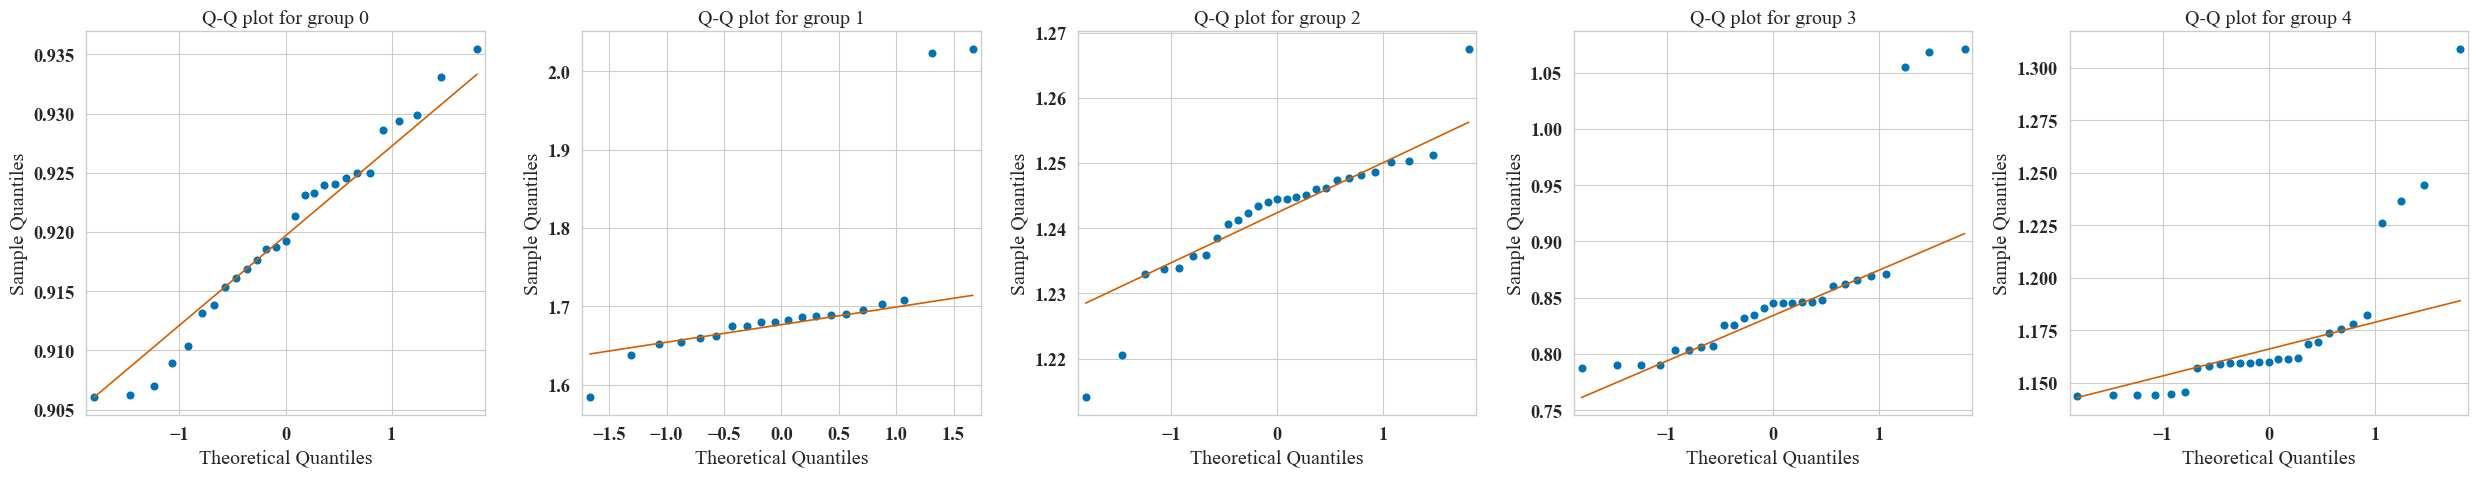

In [63]:
dependent_variable = "normalized duration"

_ = test_assumptions(
    rq1_df.query("architecture == 'MobileNet V2'")[dependent_variable],
    rq1_df.query("architecture == 'NASNet Mobile'")[dependent_variable],
    rq1_df.query("architecture == 'Xception'")[dependent_variable],
    rq1_df.query("architecture == 'ResNet50'")[dependent_variable],
    rq1_df.query("architecture == 'VGG16'")[dependent_variable],
    nrows=1,
    ncols=5,
    figsize=(25, 5),
)

###### Welch's ANOVA test


In [64]:
pg.welch_anova(rq1_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,architecture,4,53.963804,4322.381491,6.324527e-67,0.958346


###### Games-Howell post-hoc test


In [65]:
pg.pairwise_gameshowell(rq1_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,MobileNet V2,NASNet Mobile,0.919817,1.707775,-0.787958,0.025134,-31.350320,19.146908,0.000000e+00,-10.590317
1,MobileNet V2,ResNet50,0.919817,0.856898,0.062918,0.015323,4.106035,26.544069,2.910263e-03,1.101325
2,MobileNet V2,VGG16,0.919817,1.173663,-0.253847,0.007470,-33.982657,28.364350,0.000000e+00,-9.114866
3,MobileNet V2,Xception,0.919817,1.242181,-0.322364,0.002488,-129.565344,49.714716,9.214851e-15,-34.752159
4,NASNet Mobile,ResNet50,1.707775,0.856898,0.850877,0.029354,28.986690,32.394938,0.000000e+00,8.848742
5,NASNet Mobile,VGG16,1.707775,1.173663,0.534112,0.026128,20.442409,22.242406,4.440892e-16,6.698503
6,NASNet Mobile,Xception,1.707775,1.242181,0.465594,0.025160,18.505052,19.227155,9.742207e-13,6.245606
7,ResNet50,VGG16,0.856898,1.173663,-0.316765,0.016904,-18.739148,37.344083,0.000000e+00,-5.026235
8,ResNet50,Xception,0.856898,1.242181,-0.385283,0.015367,-25.072677,26.840910,0.000000e+00,-6.725021
9,VGG16,Xception,1.173663,1.242181,-0.068518,0.007558,-9.065349,29.644390,4.636638e-09,-2.431518


###### Kruskal-Wallis test


In [66]:
result_rq11 = pg.kruskal(rq1_df, dv=dependent_variable, between=independent_variable)
result_rq11

,Source,ddof1,H,p-unc
Kruskal,architecture,4,117.135793,2.184228e-24


###### Eta-squared measure


In [67]:
eta_squared(result_rq11["H"].item(), rq1_df[independent_variable].nunique(), rq1_df.shape[0])

0.9198031991624829

###### Dunn's test


In [68]:
p_values = sp.posthoc_dunn(
    rq1_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm", sort=True
)

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,MobileNet V2,NASNet Mobile,ResNet50,VGG16,Xception
MobileNet V2,False,True,False,True,True
NASNet Mobile,True,False,True,True,False
ResNet50,False,True,False,True,True
VGG16,True,True,True,False,False
Xception,True,False,True,False,False


In [69]:
mobilenet_v2 = rq1_df[dependent_variable][rq1_df["architecture"] == "MobileNet V2"]
nasnet_mobile = rq1_df[dependent_variable][rq1_df["architecture"] == "NASNet Mobile"]
xception = rq1_df[dependent_variable][rq1_df["architecture"] == "Xception"]
resnet50 = rq1_df[dependent_variable][rq1_df["architecture"] == "ResNet50"]
vgg16 = rq1_df[dependent_variable][rq1_df["architecture"] == "VGG16"]

print(f"MobileNet V2 - NASNet Mobile effect size: {cliffs_delta(mobilenet_v2, nasnet_mobile)}")
print(f"MobileNet V2 - Xception effect size: {cliffs_delta(mobilenet_v2, xception)}")
print(f"MobileNet V2 - ResNet50 effect size: {cliffs_delta(mobilenet_v2, resnet50)}")
print(f"MobileNet V2 - VGG16 effect size: {cliffs_delta(mobilenet_v2, vgg16)}")
print(f"NASNet Mobile - Xception effect size: {cliffs_delta(nasnet_mobile, xception)}")
print(f"NASNet Mobile - ResNet50 effect size: {cliffs_delta(nasnet_mobile, resnet50)}")
print(f"NASNet Mobile - VGG16 effect size: {cliffs_delta(nasnet_mobile, vgg16)}")
print(f"Xception - ResNet50 effect size: {cliffs_delta(xception, resnet50)}")
print(f"Xception - VGG16 effect size: {cliffs_delta(xception, vgg16)}")
print(f"ResNet50 - VGG16 effect size: {cliffs_delta(resnet50, vgg16)}")

MobileNet V2 - NASNet Mobile effect size: (-1.0, 'large')
MobileNet V2 - Xception effect size: (-1.0, 'large')
MobileNet V2 - ResNet50 effect size: (0.7777777777777778, 'large')
MobileNet V2 - VGG16 effect size: (-1.0, 'large')
NASNet Mobile - Xception effect size: (1.0, 'large')
NASNet Mobile - ResNet50 effect size: (1.0, 'large')
NASNet Mobile - VGG16 effect size: (1.0, 'large')
Xception - ResNet50 effect size: (1.0, 'large')
Xception - VGG16 effect size: (0.8655692729766804, 'large')
ResNet50 - VGG16 effect size: (-1.0, 'large')


#### RQ1.2 - Do gains in correctness achieved by energy-greedy architectures justify their increased energy consumption?


As we clearly see from the Q-Q plots, the F1-score data is not normally distributed. Therefore, we perform a Kruskal-Wallis test.


Shapiro test for normality of group 0: W = 0.49006783962249756 and p-value 1.3366884488164033e-08. Is normaly distributed? False
Shapiro test for normality of group 1: W = 0.9333937168121338 and p-value 0.17943550646305084. Is normaly distributed? True
Shapiro test for normality of group 2: W = 0.9689985513687134 and p-value 0.57557612657547. Is normaly distributed? True
Shapiro test for normality of group 3: W = 0.6832313537597656 and p-value 2.2853935206512688e-06. Is normaly distributed? False
Shapiro test for normality of group 4: W = 0.9694974422454834 and p-value 0.5885881185531616. Is normaly distributed? True
Levene test for equal variances: W = 8.874948713210564 and p-value = 2.494069071363159e-06. Equal variances? False


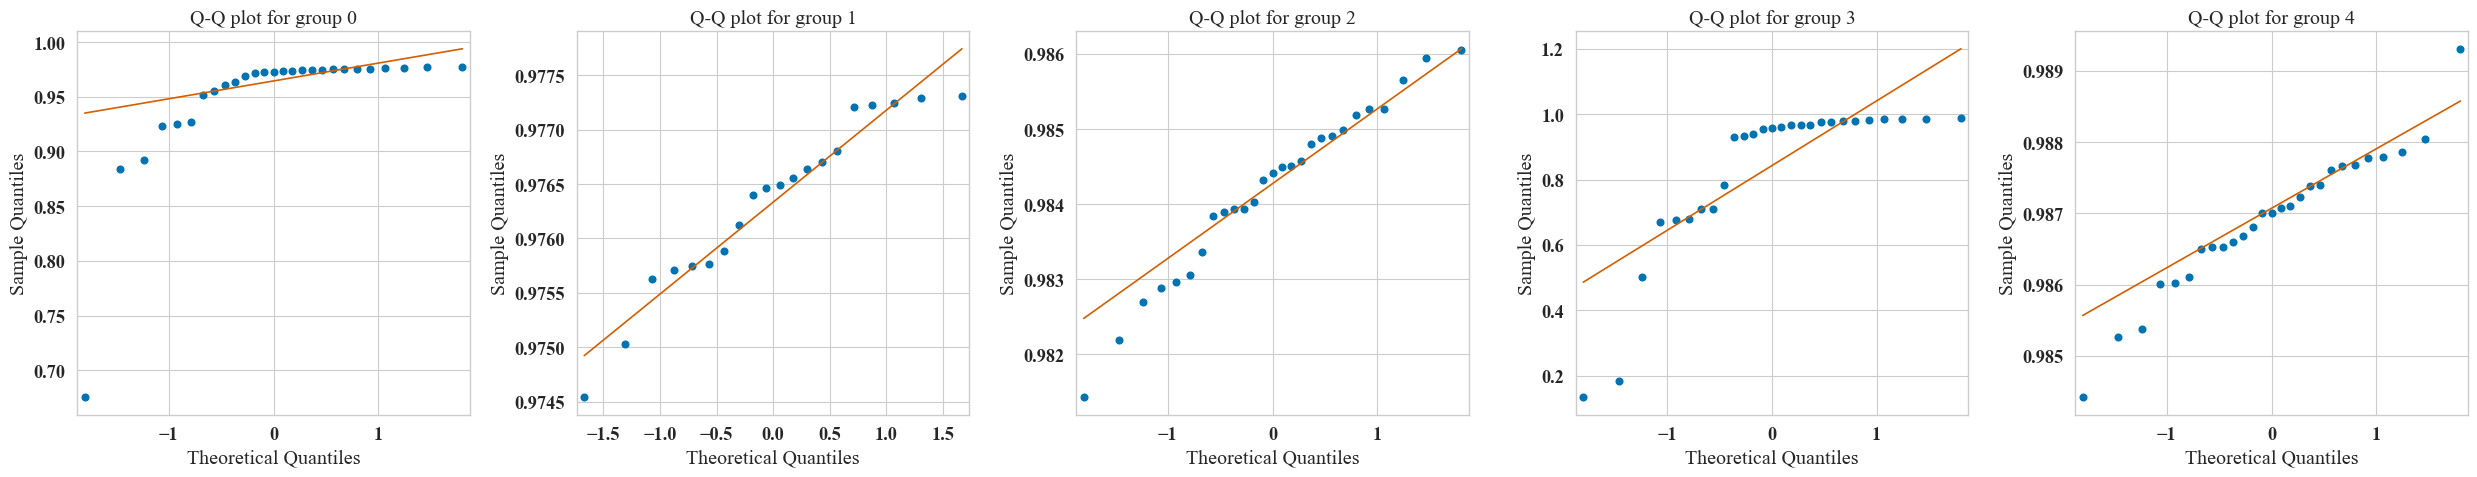

In [70]:
dependent_variable = "f1-score"

_ = test_assumptions(
    rq1_df.query("architecture == 'MobileNet V2'")[dependent_variable],
    rq1_df.query("architecture == 'NASNet Mobile'")[dependent_variable],
    rq1_df.query("architecture == 'Xception'")[dependent_variable],
    rq1_df.query("architecture == 'ResNet50'")[dependent_variable],
    rq1_df.query("architecture == 'VGG16'")[dependent_variable],
    nrows=1,
    ncols=5,
    figsize=(25, 5),
)

##### Kruskal-Wallis test


In [71]:
result_rq12 = pg.kruskal(rq1_df, dv=dependent_variable, between=independent_variable)
result_rq12

,Source,ddof1,H,p-unc
Kruskal,architecture,4,98.555282,1.996950e-20


##### Eta-squared measure


In [72]:
eta_squared(result_rq12["H"].item(), rq1_df[independent_variable].nunique(), rq1_df.shape[0])

0.768742133546266

##### Dunn's test


In [73]:
p_values = sp.posthoc_dunn(rq1_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,MobileNet V2,NASNet Mobile,ResNet50,VGG16,Xception
MobileNet V2,False,False,False,True,True
NASNet Mobile,False,False,False,True,True
ResNet50,False,False,False,True,True
VGG16,True,True,True,False,True
Xception,True,True,True,True,False


In [74]:
mobilenet_v2 = rq1_df[dependent_variable][rq1_df["architecture"] == "MobileNet V2"]
nasnet_mobile = rq1_df[dependent_variable][rq1_df["architecture"] == "NASNet Mobile"]
xception = rq1_df[dependent_variable][rq1_df["architecture"] == "Xception"]
resnet50 = rq1_df[dependent_variable][rq1_df["architecture"] == "ResNet50"]
vgg16 = rq1_df[dependent_variable][rq1_df["architecture"] == "VGG16"]

print(f"MobileNet V2 - NASNet Mobile effect size: {cliffs_delta(mobilenet_v2, nasnet_mobile)}")
print(f"MobileNet V2 - Xception effect size: {cliffs_delta(mobilenet_v2, xception)}")
print(f"MobileNet V2 - ResNet50 effect size: {cliffs_delta(mobilenet_v2, resnet50)}")
print(f"MobileNet V2 - VGG16 effect size: {cliffs_delta(mobilenet_v2, vgg16)}")
print(f"NASNet Mobile - Xception effect size: {cliffs_delta(nasnet_mobile, xception)}")
print(f"NASNet Mobile - ResNet50 effect size: {cliffs_delta(nasnet_mobile, resnet50)}")
print(f"NASNet Mobile - VGG16 effect size: {cliffs_delta(nasnet_mobile, vgg16)}")
print(f"Xception - ResNet50 effect size: {cliffs_delta(xception, resnet50)}")
print(f"Xception - VGG16 effect size: {cliffs_delta(xception, vgg16)}")
print(f"ResNet50 - VGG16 effect size: {cliffs_delta(resnet50, vgg16)}")

MobileNet V2 - NASNet Mobile effect size: (-0.7814814814814814, 'large')
MobileNet V2 - Xception effect size: (-1.0, 'large')
MobileNet V2 - ResNet50 effect size: (0.16598079561042525, 'small')
MobileNet V2 - VGG16 effect size: (-1.0, 'large')
NASNet Mobile - Xception effect size: (-1.0, 'large')
NASNet Mobile - ResNet50 effect size: (0.4703703703703704, 'medium')
NASNet Mobile - VGG16 effect size: (-1.0, 'large')
Xception - ResNet50 effect size: (0.8491083676268861, 'large')
Xception - VGG16 effect size: (-0.9382716049382716, 'large')
ResNet50 - VGG16 effect size: (-0.9561042524005487, 'large')


#### RQ1.3 - How does the complexity of a DL architecture affect energy efficiency?


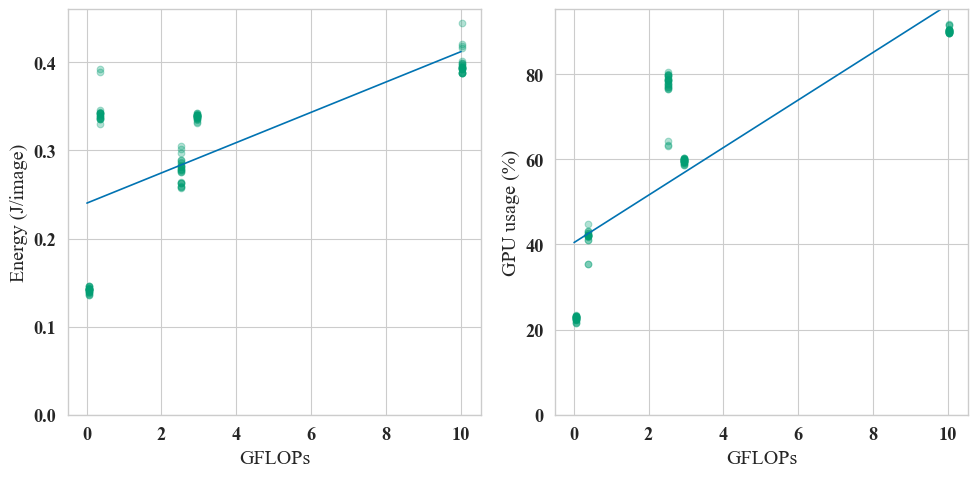

In [75]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

x = rq1_df.GFLOPs
y = rq1_df.energy

ax0.scatter(
    x,
    y,
    color=COLORS["Cloud"],
    alpha=0.3,
)

m, b = np.polyfit(x, y, 1)
samples = np.linspace(1e-2, 10, 100)
ax0.plot(samples, m * samples + b, color="b")

ax0.set_ylabel("Energy (J/image)")
ax0.set_ylim(bottom=0)
ax0.set_xlabel("GFLOPs")

y = rq1_df.gpu_usage

ax1.scatter(
    x,
    y,
    color=COLORS["Cloud"],
    alpha=0.3,
)

ax1.set_ylabel("GPU usage (%)")
ax1.set_ylim(bottom=0)
ax1.set_xlabel("GFLOPs")

# p1, p2 = np.polyfit(np.log(x), y, 1)
# ax1.plot(samples, p1 * np.log(samples) + p2, "r", label="logarithmic reg")

m, b = np.polyfit(x, y, 1)
ax1.plot(samples, m * samples + b, color="b", label="linear reg")
# ax1.legend()

if SAVE_FIGS:
    plt.savefig(os.path.join(SAVE_FIGS_DIR, f"cloud-energy-flops-regression.{FIGURES_FORMAT}"))

##### Correlation between FLOPs and Energy, and FLOPs and GPU usage


##### Local ML

Energy/FLOPs correlation


In [76]:
stats.spearmanr(
    local_ml_energy_vs_gpu_usage_df.energy,
    local_ml_energy_vs_gpu_usage_df.GFLOPs,
    alternative="greater",
)

SignificanceResult(statistic=0.9793911935183524, pvalue=1.8918975152236636e-99)

GPU usage/FLOPs correlation


In [77]:
stats.spearmanr(
    local_ml_energy_vs_gpu_usage_df.gpu_usage,
    local_ml_energy_vs_gpu_usage_df.GFLOPs,
    alternative="greater",
)

SignificanceResult(statistic=0.9793911935183524, pvalue=1.8918975152236636e-99)

##### Cloud

Energy/FLOPs correlation


In [78]:
stats.spearmanr(rq1_df.energy, rq1_df.GFLOPs, alternative="greater")

SignificanceResult(statistic=0.7981422974388114, pvalue=8.272587414729825e-30)

GPU usage/FLOPs correlation


In [79]:
stats.spearmanr(rq1_df.gpu_usage, rq1_df.GFLOPs, alternative="greater")

SignificanceResult(statistic=0.8640986988823989, pvalue=1.1086248592914777e-39)

### RQ2 - Are local environments more energy-greedy than cloud environments when training DL models?


In [80]:
rq2_df = pd.concat([local_n_mobilenet, local_ml_mobilenet, cloud_mobilenet])

#### Energy

The energy data for RQ2 is not normally distributed. Therefore, the relevant results are obtained from the Kruskal-Wallis test.


Shapiro test for normality of group 0: W = 0.8904842138290405 and p-value 0.008156336843967438. Is normaly distributed? False
Shapiro test for normality of group 1: W = 0.7080234289169312 and p-value 8.656921295369102e-07. Is normaly distributed? False
Shapiro test for normality of group 2: W = 0.9595416784286499 and p-value 0.3608037829399109. Is normaly distributed? True
Levene test for equal variances: W = 3.7236669783127536 and p-value = 0.028219282808431768. Equal variances? False


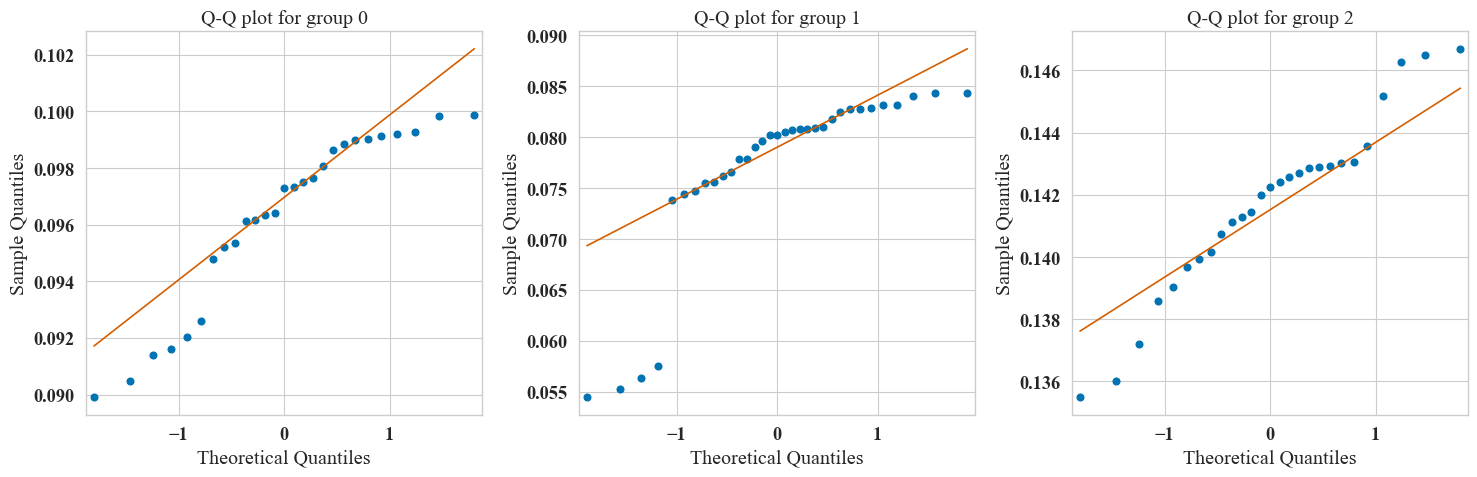

In [81]:
independent_variable = "training environment"
dependent_variable = "energy"

_ = test_assumptions(
    rq2_df.query("`training environment` == 'Local N'")[dependent_variable],
    rq2_df.query("`training environment` == 'Local ML'")[dependent_variable],
    rq2_df.query("`training environment` == 'Cloud'")[dependent_variable],
    nrows=1,
    ncols=3,
    figsize=(15, 5),
)

##### Welch's ANOVA test


In [82]:
pg.welch_anova(rq2_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,training environment,2,54.270986,1959.572484,2.530810e-51,0.958326


##### Tukey post-hoc test


In [83]:
pg.pairwise_gameshowell(rq2_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Cloud,Local ML,0.141688,0.077018,0.064670,0.001582,40.868051,40.526129,0.000000e+00,9.652392
1,Cloud,Local N,0.141688,0.096264,0.045425,0.000807,56.298118,51.790052,1.998401e-15,15.100343
2,Local ML,Local N,0.077018,0.096264,-0.019246,0.001595,-12.062731,41.599865,1.210143e-14,-2.856175


##### Kruskal-Wallis test


In [84]:
result_rq21 = pg.kruskal(rq2_df, dv=dependent_variable, between=independent_variable)
result_rq21

,Source,ddof1,H,p-unc
Kruskal,training environment,2,76.175549,2.875344e-17


##### Eta-squared measure


In [85]:
eta_squared(result_rq21["H"].item(), rq2_df[independent_variable].nunique(), rq2_df.shape[0])

0.8830422451112108

##### Dunn's test


In [86]:
p_values = sp.posthoc_dunn(rq2_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,Cloud,Local ML,Local N
Cloud,False,True,True
Local ML,True,False,True
Local N,True,True,False


In [87]:
local = rq2_df[dependent_variable][rq2_df["training environment"] == "Local N"]
local_ml = rq2_df[dependent_variable][rq2_df["training environment"] == "Local ML"]
Cloud = rq2_df[dependent_variable][rq2_df["training environment"] == "Cloud"]

print(f"Local - Local ML effect size: {cliffs_delta(local, local_ml)}")
print(f"Local - Cloud effect size: {cliffs_delta(local, Cloud)}")
print(f"Local ML - Cloud effect size: {cliffs_delta(local_ml, Cloud)}")

Local - Local ML effect size: (1.0, 'large')
Local - Cloud effect size: (-1.0, 'large')
Local ML - Cloud effect size: (-1.0, 'large')


#### GPU usage

As with the energy data, GPU usage data is not normally distributed. Therefore, the relevant results are obtained from the Kruskal-Wallis test.


In [88]:
local = rq2_df.gpu_usage[rq2_df["training environment"] == "Local N"]
local_ml = rq2_df.gpu_usage[rq2_df["training environment"] == "Local ML"]
Cloud = rq2_df.gpu_usage[rq2_df["training environment"] == "Cloud"]

dependent_variable = "gpu_usage"

Shapiro test for normality of group 0: W = 0.9240078926086426 and p-value 0.04935179650783539. Is normaly distributed? False
Shapiro test for normality of group 1: W = 0.6587541103363037 and p-value 1.638209568000093e-07. Is normaly distributed? False
Shapiro test for normality of group 2: W = 0.9207553863525391 and p-value 0.04117055982351303. Is normaly distributed? False
Levene test for equal variances: W = 7.721538459248591 and p-value = 0.0008348313793417753. Equal variances? False


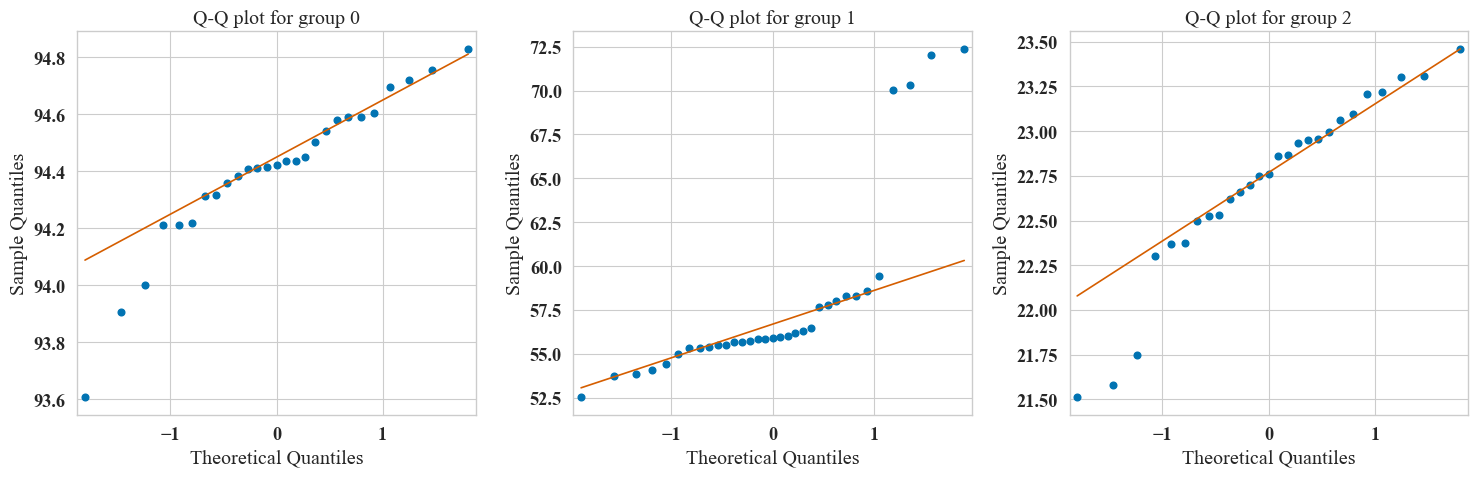

In [89]:
_ = test_assumptions(local, local_ml, Cloud, nrows=1, ncols=3, figsize=(15, 5))

##### Welch's ANOVA test


In [90]:
pg.welch_anova(rq2_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,training environment,2,47.242794,213199.28027,3.671949e-94,0.987285


##### Games-Howell post-hoc test


In [91]:
pg.pairwise_gameshowell(rq2_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Cloud,Local ML,22.708816,57.843996,-35.135180,0.920761,-38.158865,32.707997,0.0,-8.842996
1,Cloud,Local N,22.708816,94.404697,-71.695881,0.109094,-657.190833,39.551736,0.0,-176.272448
2,Local ML,Local N,57.843996,94.404697,-36.560701,0.917128,-39.864353,32.199314,0.0,-9.226050


##### Kruskal-Wallis test


In [92]:
result_rq22 = pg.kruskal(rq2_df, dv=dependent_variable, between=independent_variable)
result_rq22

,Source,ddof1,H,p-unc
Kruskal,training environment,2,76.175549,2.875344e-17


##### Eta-squared measure


In [93]:
eta_squared(result_rq22["H"].item(), rq2_df[independent_variable].nunique(), rq2_df.shape[0])

0.8830422451112108

##### Dunn's test


In [94]:
p_values = sp.posthoc_dunn(rq2_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,Cloud,Local ML,Local N
Cloud,False,True,True
Local ML,True,False,True
Local N,True,True,False


In [95]:
print(f"Local - Local ML effect size: {cliffs_delta(local, local_ml)}")
print(f"Local - Cloud effect size: {cliffs_delta(local, Cloud)}")
print(f"Local ML - Cloud effect size: {cliffs_delta(local_ml, Cloud)}")

Local - Local ML effect size: (1.0, 'large')
Local - Cloud effect size: (1.0, 'large')
Local ML - Cloud effect size: (1.0, 'large')


#### Processing time

As with the energy data, data is not normally distributed. Therefore, the relevant results are obtained from the Kruskal-Wallis test.


In [96]:
local = rq2_df.gpu_usage[rq2_df["training environment"] == "Local N"]
local_ml = rq2_df.gpu_usage[rq2_df["training environment"] == "Local ML"]
Cloud = rq2_df.gpu_usage[rq2_df["training environment"] == "Cloud"]

dependent_variable = "normalized duration"

Shapiro test for normality of group 0: W = 0.9240078926086426 and p-value 0.04935179650783539. Is normaly distributed? False
Shapiro test for normality of group 1: W = 0.6587541103363037 and p-value 1.638209568000093e-07. Is normaly distributed? False
Shapiro test for normality of group 2: W = 0.9207553863525391 and p-value 0.04117055982351303. Is normaly distributed? False
Levene test for equal variances: W = 7.721538459248591 and p-value = 0.0008348313793417753. Equal variances? False


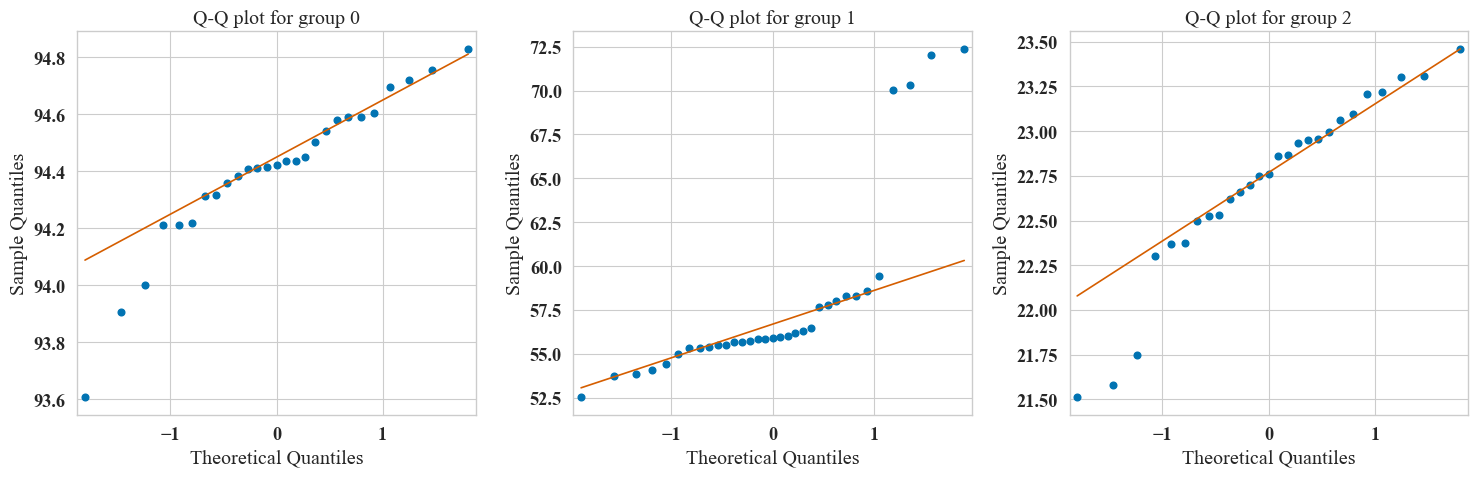

In [97]:
_ = test_assumptions(local, local_ml, Cloud, nrows=1, ncols=3, figsize=(15, 5))

##### Welch's ANOVA test


In [98]:
pg.welch_anova(rq2_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,training environment,2,38.983997,5787.761351,5.950670e-49,0.995034


##### Games-Howell post-hoc test


In [99]:
pg.pairwise_gameshowell(rq2_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Cloud,Local ML,0.919817,0.595088,0.324729,0.013681,23.736278,32.840963,8.215650e-15,5.502567
1,Cloud,Local N,0.919817,2.905138,-1.985322,0.018792,-105.648356,26.360524,0.000000e+00,-28.337118
2,Local ML,Local N,0.595088,2.905138,-2.310050,0.023139,-99.832110,49.455656,0.000000e+00,-26.140151


##### Kruskal-Wallis test


In [100]:
result_rq22 = pg.kruskal(rq2_df, dv=dependent_variable, between=independent_variable)
result_rq22

,Source,ddof1,H,p-unc
Kruskal,training environment,2,76.175549,2.875344e-17


##### Eta-squared measure


In [101]:
eta_squared(result_rq22["H"].item(), rq2_df[independent_variable].nunique(), rq2_df.shape[0])

0.8830422451112108

##### Dunn's test


In [102]:
p_values = sp.posthoc_dunn(rq2_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,Cloud,Local ML,Local N
Cloud,False,True,True
Local ML,True,False,True
Local N,True,True,False


In [103]:
print(f"Local - Local ML effect size: {cliffs_delta(local, local_ml)}")
print(f"Local - Cloud effect size: {cliffs_delta(local, Cloud)}")
print(f"Local ML - Cloud effect size: {cliffs_delta(local_ml, Cloud)}")

Local - Local ML effect size: (1.0, 'large')
Local - Cloud effect size: (1.0, 'large')
Local ML - Cloud effect size: (1.0, 'large')


### Annex

#### Interaction between training environment and architecture for energy consumption

##### Two-way ANOVA

Shapiro test for normality of group 0: W = 0.9595416784286499 and p-value 0.3608037829399109. Is normaly distributed? True
Shapiro test for normality of group 1: W = 0.7080234289169312 and p-value 8.656921295369102e-07. Is normaly distributed? False
Shapiro test for normality of group 2: W = 0.5738625526428223 and p-value 1.5973427025528508e-06. Is normaly distributed? False
Shapiro test for normality of group 3: W = 0.9803736805915833 and p-value 0.8706938624382019. Is normaly distributed? True
Shapiro test for normality of group 4: W = 0.9439828991889954 and p-value 0.1527511328458786. Is normaly distributed? True
Shapiro test for normality of group 5: W = 0.9150703549385071 and p-value 0.0300825797021389. Is normaly distributed? False
Shapiro test for normality of group 6: W = 0.7000036239624023 and p-value 3.877612016367493e-06. Is normaly distributed? False
Shapiro test for normality of group 7: W = 0.9376377463340759 and p-value 0.0962534248828888. Is normaly distributed? True
Sh

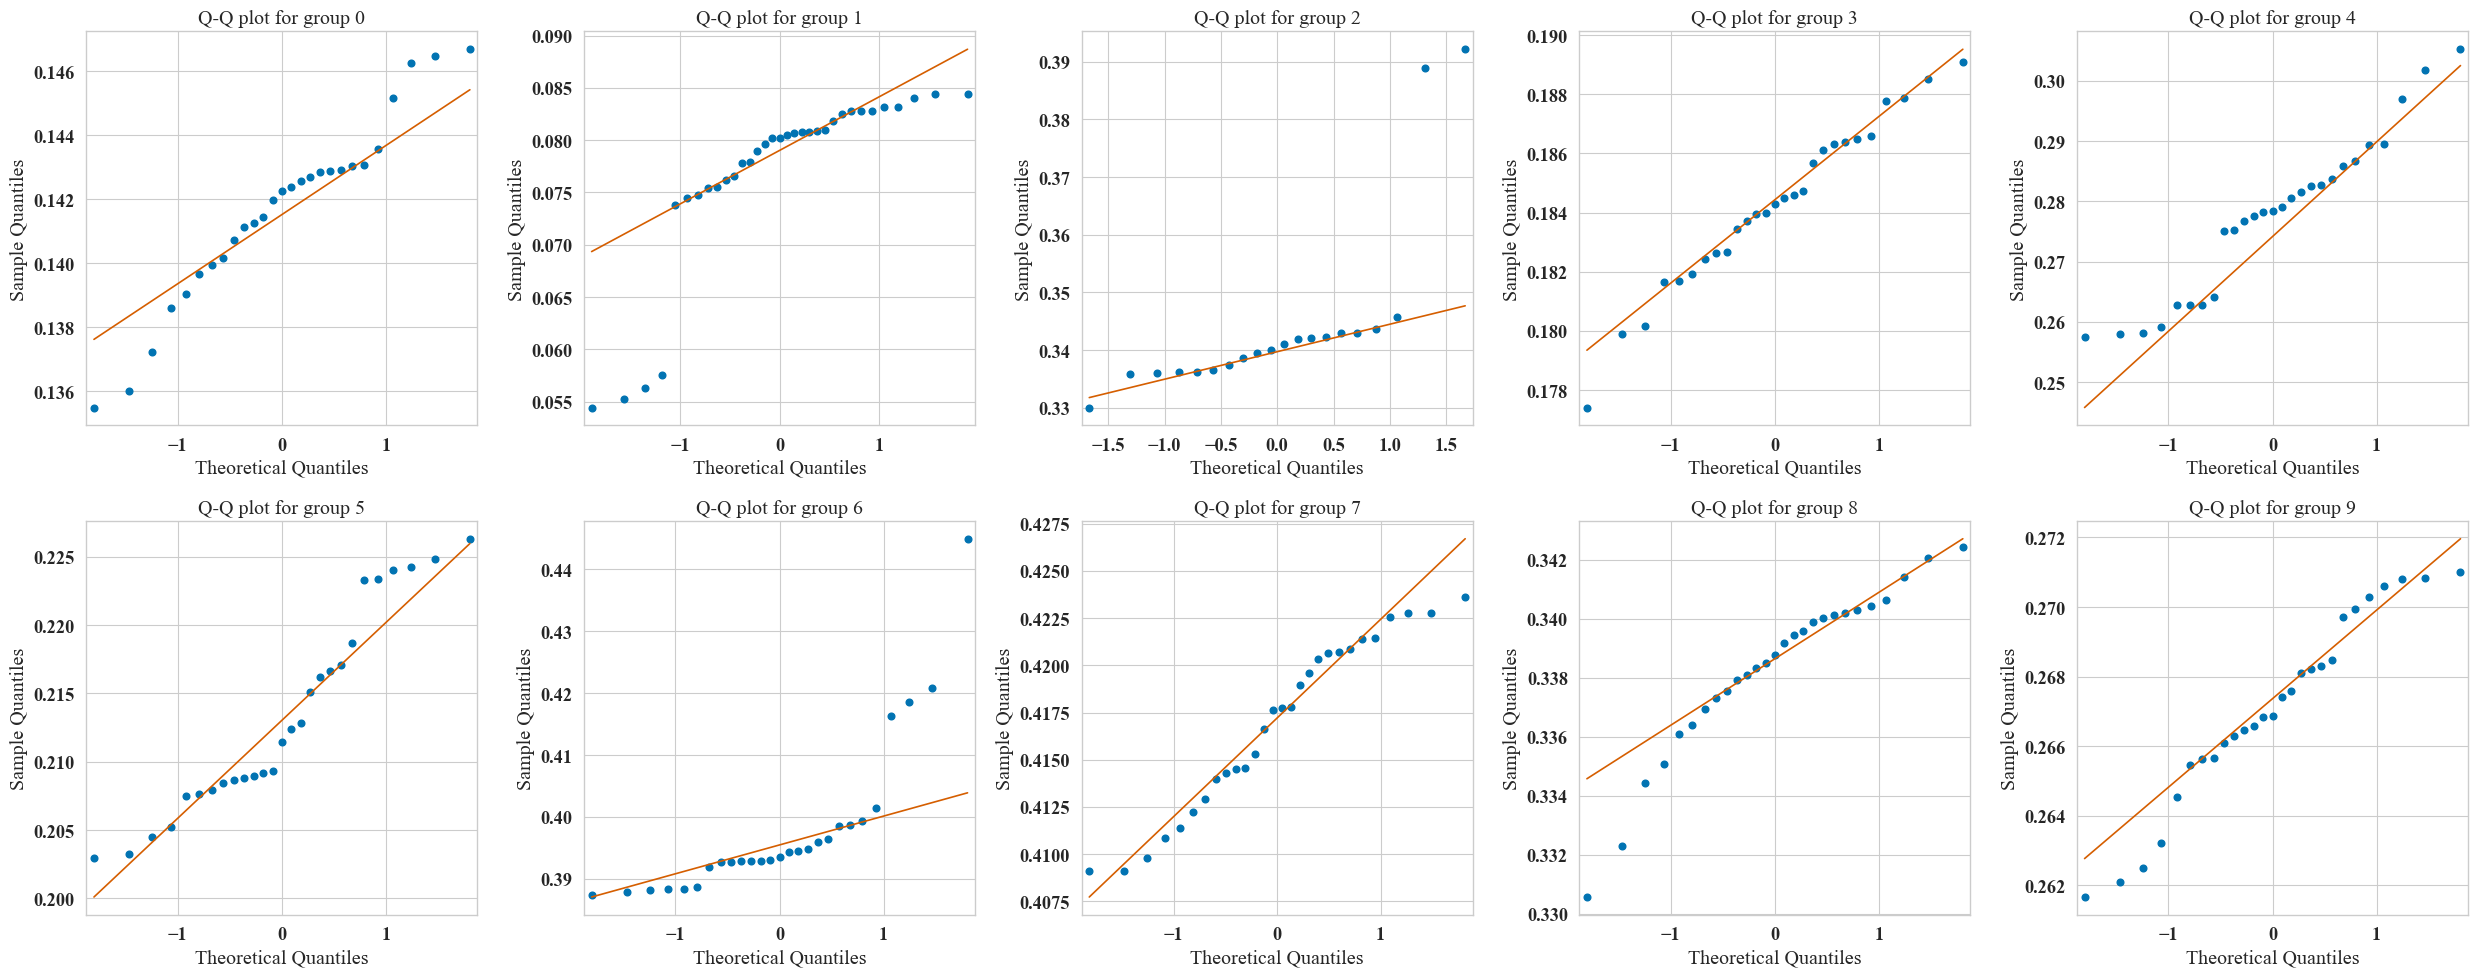

In [104]:
dependent_variable = "energy"
factor_1 = "architecture"
factor_2 = "training environment"

anex_df = analysis_df.query("`training environment` != 'Local N'")

_ = test_assumptions(
    *[group[dependent_variable] for _, group in anex_df.groupby([factor_1, factor_2])],
    nrows=2,
    ncols=5,
    figsize=(25, 10),
)

In [105]:
pg.anova(
    data=anex_df,
    dv=dependent_variable,
    between=[factor_1, factor_2],
    detailed=True,
)

,Source,SS,DF,MS,F,p-unc,np2
0,architecture,2.676546,4.0,0.669137,9157.202878,2.314472e-278,0.992952
1,training environment,0.284748,1.0,0.284748,3896.801148,1.643553e-158,0.937452
2,architecture * training environment,0.201593,4.0,0.050398,689.705939,4.426866e-137,0.913874
3,Residual,0.018999,260.0,0.000073,NaN,NaN,NaN
